### Step 1: Obtain Data

In [20]:
import os
import shutil
from PIL import Image
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

# Folder setup
source_folder = 'Other_Animal_Images_TREE'
destination_folder = 'Other_Animal_Images_TREE_Preprocessed'
os.makedirs(destination_folder, exist_ok=True)

# Get list of image filepaths
other_animal_filepaths = [os.path.join(source_folder, fname) for fname in os.listdir(source_folder) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Load the pre-trained DETR model and processor
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
model.eval()

# Loop through all images
for filepath in other_animal_filepaths:
    filename = os.path.basename(filepath)
    dest_path = os.path.join(destination_folder, filename)

    # Copy image to destination folder
    shutil.copy2(filepath, dest_path)

    # Open copied image
    with Image.open(dest_path) as img:
        # Preprocess image and run the model
        img = img.convert('RGB')
        inputs = processor(images=img, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the bounding boxes
        target_sizes = torch.tensor([img.size[::-1]])  # (H, W)
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

        if len(results['boxes']) > 0:
            # Use the first bounding box
            box = results['boxes'][0].tolist()
            left, top, right, bottom = box

            # Crop the image around the bounding box
            cropped_img = img.crop((left, top, right, bottom))

            # Convert cropped image to grayscale
            grayscale_img = cropped_img.convert('L')
        else:
            # Convert full image to grayscale if no objects are detected
            grayscale_img = img.convert('L')

        # Save the processed grayscale image
        grayscale_img.save(dest_path)


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Step 2: Create baseline x_train and y_train (without the splits)

In [25]:
# Suppress warnings
import os
import pandas as pd

from PIL import Image
import warnings

# Define base folders
pangolin_folder = "Pangolin_Images_3_12_Preprocessed"
other_animals_folder = "Other_Animal_Images_TREE_Preprocessed"

# Get the list of files in each folder
pangolin_files = [f for f in os.listdir(pangolin_folder) if f.endswith('.JPG')]
other_animal_files = [f for f in os.listdir(other_animals_folder) if f.endswith('.JPG')]

# Create file paths for each image
pangolin_filepaths = [os.path.join(pangolin_folder, f) for f in pangolin_files]
other_animal_filepaths = [os.path.join(other_animals_folder, f) for f in other_animal_files]

# Suppress warnings
warnings.filterwarnings("ignore")

# Convert each image in Other_Animal_Images_TREE to grayscale
for filepath in other_animal_filepaths:
    img = Image.open(filepath)
    grayscale_img = img.convert("L")  # Convert to grayscale
    grayscale_img.save(filepath)  # Overwrite the original file


# Combine file paths and create labels
filepaths = pangolin_filepaths + other_animal_filepaths
labels = [1] * len(pangolin_filepaths) + [0] * len(other_animal_filepaths)

# Create the DataFrame for x_train
x_train = pd.DataFrame(filepaths, columns=['filepath'])

# Create the DataFrame for y_train with binary labels
y_train = pd.DataFrame(labels, columns=['label'])

# Set the index to be the filename without the '.JPG' extension
x_train.index = [os.path.splitext(os.path.basename(f))[0] for f in filepaths]
y_train.index = x_train.index  # Use the same index for y_train

# Set column names
x_train.index.name = 'id'
y_train.index.name = 'id'

# Combine x_train and y_train into a single DataFrame
combined_df = pd.concat([x_train], axis=1)
#y_train = y_train.to_numpy().argmax(axis=1)
# Print the combined DataFrame
#print(combined_df.head())
#print(x_train.head)
y_train = y_train["label"].to_numpy()
print(y_train)
print(len(y_train))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [26]:
from PIL import Image

# Check if all images in x_train are grayscale
all_grayscale = True

for path in x_train['filepath']:
    with Image.open(path) as img:
        if img.mode != 'L':  # 'L' means 8-bit pixels, black and white
            print(f"Not grayscale: {path} (mode: {img.mode})")
            all_grayscale = False

if all_grayscale:
    print("✅ All images in x_train are grayscale.")
else:
    print("❌ Some images in x_train are not grayscale.")


✅ All images in x_train are grayscale.


### Step 3: The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [27]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        # This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`
        # Will instantiate the dataset object with 2 dataframes
        # x_train_df = contains image IDs and image file paths
        # y_train_df = contains image IDs and labels
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)), # resizes image to 224x224 pixels
                transforms.ToTensor(), # converts image to a PyTorch Tensor, normalizing pixel values b/w 0 and 1
                transforms.Normalize( # standardizes image using mean and standard dev of the ImageNet dataset
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        filepath = self.data.iloc[index]["filepath"]
        # Skip non-image files like .DS_Store
        if filepath.endswith(".DS_Store"):
            print(filepath)

        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB") # Opens image from filepath and converts it to RBG image
        image = self.transform(image) # Applies transformation pipeline (resize, tensor conversion, normalization)
        image_id = self.data.index[index] # Retrieves image ID
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image} # If no label, returns dictionary with just image_id and transformed image (so if no y_df)
        else: # If label: 
            label = torch.tensor(self.label[index], 
                                 dtype=torch.float) # Converts label into a PyTorch Tensor
            sample = {"image_id": image_id, "image": image, "label": label} # Returns a dictionary containing image_id, image, and label
        return sample

    def __len__(self): # Returns # of images in x_df (length of dataset)
        return len(self.data)

## STEP 4: Training

#### STRATIFIED KFOLD
For K_Fold:
- 80% train, 20% test
- Within train, we further split:
- 90% train, 10% val
- Train and validate for 15 epochs/fold
- Save the best model as that which produces the lowest val loss
- Run the best model of each fold on the test data for that fold


In [29]:
from torch.utils.data import DataLoader 
from PIL import Image
import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch import nn  # import neural network from PyTorch
import torchvision.models as models  # import models submodule (includes pre-trained models used for computer vision)
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import math
from torchmetrics.classification import BinaryAccuracy




import time  # Import the time module for tracking training time

# Store feature maps for each layer
feature_maps = {}

# Define the hook function to save feature maps
def hook_fn(module, input, output, layer_name):
    feature_maps[layer_name] = output.detach()


# Define a function that trains and evaluates the model for a specified number of epochs
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []  # To store metrics like accuracy, precision, etc. for each epoch
    per_species_train_metrics = {  # Store per-species metrics for training
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    per_species_val_metrics = {  # Store per-species metrics for validation
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    train_times = []  # List to store the time for each epoch

    model_save_path = []  # To store the best model based on validation loss
    # Specify the layers you want to visualize
    layers_to_visualize = ['features.denseblock1', 'features.denseblock2', 'features.denseblock3', 'features.denseblock4', 'features.transition1', 'features.transition2']

    # Register hooks for each layer
    hooks = []
    for layer_name in layers_to_visualize:
        layer = dict([*model.named_modules()])[layer_name]  # Get the layer by name
        hook = layer.register_forward_hook(lambda module, input, output, name=layer_name: hook_fn(module, input, output, name))
        hooks.append(hook)


    for epoch in range(num_epochs):
        start_time = time.time()  # Start the timer at the beginning of the epoch

        model.train()  # Set the model to train mode
        train_loss, train_preds, train_labels = 0, [], []
        train_probs = []
        train_outputs = []
        train_auc = 0

        # Training loop:
        for batch in train_loader:
            images = batch['image']
            labels = batch['label'] # CHANGED
            labels = labels.unsqueeze(1).float()
            #labels = torch.argmax(labels, dim=1)  # Convert to 1D tensor of class indices
            #print(f"Unique labels in train batch: {torch.unique(labels)}")

            optimizer.zero_grad()
            outputs = model(images)  # Obtains predictions
            loss = criterion(outputs, labels)  # Computes the loss
            loss.backward()  # Backprop to compute the gradients
            optimizer.step()  # Updates the model weights based on gradients

            # Save train loss
            train_loss += loss.item()  # Accumulates the loss for the batch
            preds = (outputs > 0.5).int()  # binary predictions: 0 or 1
            train_preds.extend(preds.cpu().numpy())
            #train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  CHANGED
            train_labels.extend(labels.cpu().numpy())  # Stores the true labels for the batch

            # Add AUC calculation for training
            #train_outputs.extend(outputs.cpu().detach().numpy())  # Get probabilities for each class
            #train_auc = roc_auc_score(train_labels, train_outputs.cpu().detach().numpy(), average='macro', multi_class='ovr')
            #train_probs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy()) CHANGED
            train_probs.extend(outputs.cpu().detach().numpy())
        
        # Visualization after each epoch
        # Find indices of one pangolin and one non-pangolin
        # pangolin_idx = (labels == 1).nonzero(as_tuple=True)[0][0].item()  # First pangolin
        # non_pangolin_idx = (labels == 0).nonzero(as_tuple=True)[0][0].item()  # First non-pangolin
        # fig, axes = plt.subplots(len(layers_to_visualize) + 1, 2, figsize=(12, 25), dpi=150)  # Increased DPI for better resolution

        # for i, layer_name in enumerate(layers_to_visualize):
        #     # Display Pangolin original image
        #     axes[0][0].imshow(images[pangolin_idx].cpu().numpy().transpose(1, 2, 0))
        #     axes[0][0].set_xticks([]); axes[0][0].set_yticks([])
        #     axes[0][0].set_title("Pangolin - Original Image")

        #     # Display Non-Pangolin original image
        #     axes[0][1].imshow(images[non_pangolin_idx].cpu().numpy().transpose(1, 2, 0))
        #     axes[0][1].set_xticks([]); axes[0][1].set_yticks([])
        #     axes[0][1].set_title("Non-Pangolin - Original Image")

        #     # Display feature maps for Pangolin image
        #     fmap_pangolin = feature_maps[layer_name][pangolin_idx]  # Feature map for Pangolin image
        #     fmap_pangolin = (fmap_pangolin - fmap_pangolin.min()) / (fmap_pangolin.max() - fmap_pangolin.min())  # Normalize
        #     num_channels = fmap_pangolin.shape[0]
            
        #     random_channel_pangolin = np.random.randint(0, num_channels)  # Pick a random channel for pangolin
        #     feature_map_pangolin = fmap_pangolin[random_channel_pangolin].cpu().numpy()

        #     axes[i + 1][0].imshow(feature_map_pangolin, cmap='viridis')
        #     axes[i + 1][0].set_xticks([]); axes[i + 1][0].set_yticks([])
        #     axes[i + 1][0].set_title(f"{layer_name} - FM {random_channel_pangolin}")

        #     # Display feature maps for Non-Pangolin image
        #     fmap_non_pangolin = feature_maps[layer_name][non_pangolin_idx]  # Feature map for Non-Pangolin image
        #     fmap_non_pangolin = (fmap_non_pangolin - fmap_non_pangolin.min()) / (fmap_non_pangolin.max() - fmap_non_pangolin.min())  # Normalize
        #     random_channel_non_pangolin = np.random.randint(0, num_channels)  # Pick a random channel for non-pangolin
        #     feature_map_non_pangolin = fmap_non_pangolin[random_channel_non_pangolin].cpu().numpy()

        #     axes[i + 1][1].imshow(feature_map_non_pangolin, cmap='viridis')
        #     axes[i + 1][1].set_xticks([]); axes[i + 1][1].set_yticks([])
        #     axes[i + 1][1].set_title(f"{layer_name} - FM {random_channel_non_pangolin}")




        # plt.show()


        train_outputs = np.array(train_probs)
        train_labels = np.array(train_labels)
        
        #train_auc = roc_auc_score(train_labels, train_outputs[:, 1], average='macro', multi_class='ovr')
        train_auc = roc_auc_score(train_labels, train_probs)


        train_loss /= len(train_loader)  # Computes the average training loss for the epoch
        train_losses.append(train_loss)  # Stores the average training loss for this epoch

        # Calculate per-species metrics for training
        train_labels_tensor = torch.tensor(train_labels)
        train_preds_tensor = torch.tensor(train_preds)

        accuracy_metric = BinaryAccuracy()
        accuracy_metric.update(train_preds_tensor, train_labels_tensor)
        binary_accuracy = accuracy_metric.compute().item()
        species_train_accuracy = [1 - binary_accuracy, binary_accuracy]

        species_train_precision = precision_score(train_labels, train_preds, average=None)  # Per-class precision
        species_train_recall = recall_score(train_labels, train_preds, average=None)  # Per-class recall
        species_train_f1 = f1_score(train_labels, train_preds, average=None)  # Per-class F1 score
        
        # Calculate per-species AUC for training
        species_train_auc = []
        for i in range(len(species_train_accuracy)):  # Loop through each class
            # Calculate the AUC for each class
            auc = roc_auc_score(train_labels, train_probs)
            species_train_auc.append(auc)

        per_species_train_metrics['accuracy'].append(species_train_accuracy)
        per_species_train_metrics['precision'].append(species_train_precision)
        per_species_train_metrics['recall'].append(species_train_recall)
        per_species_train_metrics['f1'].append(species_train_f1)
        per_species_train_metrics['auc'].append(species_train_auc)  # Append AUC values for training

        # Calculate overall metrics for training
        train_accuracy = accuracy_score(train_labels, train_preds)  # Overall accuracy
        train_precision = precision_score(train_labels, train_preds, average='macro')  # Overall precision (macro-average)
        train_recall = recall_score(train_labels, train_preds, average='macro')  # Overall recall (macro-average)
        train_f1 = f1_score(train_labels, train_preds, average='macro')  # Overall F1 score (macro-average)

        train_metrics.append({
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'auc': train_auc
        })

        # Validation Loop:
        model.eval()  # Set the model to evaluation mode
        val_loss, val_preds, val_labels = 0, [], []
        val_probs = []
        val_auc = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image']
                labels = batch['label'].unsqueeze(1).float()

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Binary prediction: 1 if output > 0.5, else 0
                preds = (outputs > 0.5).int()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                # For AUC, store sigmoid probabilities
                val_probs.extend(outputs.cpu().detach().numpy())

        val_loss /= len(val_loader)  # Computes the average validation loss for this epoch
        

        # Calculate per-species metrics for validation
        species_val_precision = precision_score(val_labels, val_preds, average=None)  # Per-class precision
        species_val_recall = recall_score(val_labels, val_preds, average=None)  # Per-class recall
        species_val_f1 = f1_score(val_labels, val_preds, average=None)  # Per-class F1 score

        
        val_labels_tensor = torch.tensor(val_labels)  # Make sure to convert them to torch tensors
        val_preds_tensor = torch.tensor(val_preds)

        accuracy_metric = MulticlassAccuracy(num_classes=2, average=None)
        accuracy_metric.update(val_preds_tensor, val_labels_tensor)
        species_val_accuracy = accuracy_metric.compute().tolist()

        val_auc = roc_auc_score(np.array(val_labels).flatten(), np.array(val_probs).flatten())


        # Calculate per-species AUC for validation
        species_val_auc = []
        #for i in range(len(species_val_accuracy)):  # Loop through each class
            # Calculate the AUC for each class
            #auc = roc_auc_score([1 if label == i else 0 for label in val_labels], [prob[i] for prob in val_probs])
            #species_val_auc.append(auc)

        per_species_val_metrics['accuracy'].append(species_val_accuracy)
        per_species_val_metrics['precision'].append(species_val_precision)
        per_species_val_metrics['recall'].append(species_val_recall)
        per_species_val_metrics['f1'].append(species_val_f1)
        per_species_val_metrics['auc'].append(species_val_auc)



        # Calculate overall metrics for validation
        val_accuracy = accuracy_score(val_labels, val_preds)  # Overall accuracy
        val_precision = precision_score(val_labels, val_preds, average='macro')  # Overall precision (macro-average)
        val_recall = recall_score(val_labels, val_preds, average='macro')  # Overall recall (macro-average)
        val_f1 = f1_score(val_labels, val_preds, average='macro')  # Overall F1 score (macro-average)

        val_metrics.append({
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auc': val_auc
        })

        # Save the model with the lowest validation loss
        
        if epoch == 0 or val_loss < min(val_losses):
            if epoch != 0: 
                print(min(val_losses))
            print("Saving for this epoch", epoch)
            model_save_path = model.state_dict()
        val_losses.append(val_loss)  # Stores the average validation loss for this epoch


        # Print per-species metrics and overall metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Print per-species metrics for training
       # Print per-species metrics for training
        print("Training Per-Species Metrics:")
    
        for idx in range(len(species_train_accuracy)):
            #print(f"Species {idx} - Accuracy: {species_train_accuracy[idx]:.4f}, Precision: {species_train_precision[idx]:.4f}, Recall: {species_train_recall[idx]:.4f}, F1: {species_train_f1[idx]:.4f}")
            # Check if idx is within the bounds of other metrics
            if idx == 1:
                print(f"Species {idx} - Accuracy: {species_train_accuracy[idx]:.4f}, Precision: {species_train_precision[idx]:.4f}, Recall: {species_train_recall[idx]:.4f}, F1: {species_train_f1[idx]:.4f}")
            else:
                print(f"Precision: {species_train_precision[idx]:.4f}, Recall: {species_train_recall[idx]:.4f}, F1: {species_train_f1[idx]:.4f}")
            #if idx < len(species_train_precision) and idx < len(species_train_recall) and idx < len(species_train_f1):
                #print(f"Species {idx} - Accuracy: {species_train_accuracy[idx]:.4f}, Precision: {species_train_precision[idx]:.4f}, Recall: {species_train_recall[idx]:.4f}, F1: {species_train_f1[idx]:.4f}")
            #else:
                #print(f"Species {idx} - Accuracy: {species_train_accuracy[idx]:.4f}, Precision: N/A, Recall: N/A, F1: N/A")
                

        # Print overall metrics for training
        print(f"Training Overall Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")

       # Print per-species metrics for validation
        #print("Validation Per-Species Metrics:")
        #for idx in range(len(species_val_accuracy)):
            # Check if idx is within the bounds of other metrics
            #if idx < len(species_val_precision) and idx < len(species_val_recall) and idx < len(species_val_f1):
                #print(f"Species {idx} - Accuracy: {species_val_accuracy[idx]:.4f}, Precision: {species_val_precision[idx]:.4f}, Recall: {species_val_recall[idx]:.4f}, F1: {species_val_f1[idx]:.4f}")
            #else:
                #print(f"Species {idx} - Accuracy: {species_val_accuracy[idx]:.4f}, Precision: N/A, Recall: N/A, F1: N/A")
                
        # Print overall metrics for validation
        print(f"Validation Overall Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Calculate training time for this epoch
        end_time = time.time()
        epoch_time = end_time - start_time
        print("Epoch time", epoch_time)
        train_times.append(epoch_time)
        print("\n\n")

    return model_save_path, train_losses, val_losses, val_metrics, train_metrics, per_species_train_metrics, per_species_val_metrics, train_times

###### KFOLD CROSS VALIDATION ########
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Shuffle data with random_seed = 42 for reproducibility
all_train_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}
all_val_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

all_test_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

all_per_species_train_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}
all_per_species_val_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

all_per_species_test_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [], 
    'auc': []
}
all_train_times = []
all_train_losses = []
all_validation_loss = []


#y_train = y_train.argmax(axis=1)
#for fold, (train_index, test_index) in enumerate(kf.split(combined_df)):
for fold, (train_index, test_index) in enumerate(strat_kf.split(combined_df, y_train)):  # Stratified split
    print(f"Fold {fold+1}/{5}")

    # Split data
    train_data = x_train.iloc[train_index]  # File paths for training set
    test_data = x_train.iloc[test_index]  # File paths for testing set
    train_labels = y_train[train_index]  # Labels for training set
    test_labels = y_train[test_index]  # Labels for testing set
    
    # Further split the training data into training and validation (90/10 split)
        #train_data, val_data = train_data[:int(0.9 * len(train_data))], train_data[int(0.9 * len(train_data)):]
        #train_labels, val_labels = train_labels[:int(0.9 * len(train_labels))], train_labels[int(0.9 * len(train_labels)):]
   # Perform stratified split while maintaining original proportions
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels,  # Original training data and labels
        test_size=0.1,  # 10% of train_data becomes val_data
        stratify=train_labels,  # Ensures class proportions are preserved
        random_state=42  # For reproducibility
    )


    # Filter out .DS_Store files from train, validation, and test data
    train_data = train_data[~train_data['filepath'].str.endswith('.DS_Store')]
    val_data = val_data[~val_data['filepath'].str.endswith('.DS_Store')]
    test_data = test_data[~test_data['filepath'].str.endswith('.DS_Store')]



    # Create Dataloader for this fold
    train_dataset = ImagesDataset(train_data, train_labels)  # Ensure transform is defined
    val_dataset = ImagesDataset(val_data, val_labels)
    test_dataset = ImagesDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    
    

    model = models.densenet121(pretrained=True)  
    model.classifier = nn.Sequential(  # Replace the classifier layer
        nn.Linear(1024, 100),  # Dense layer takes a 1024-dim input and outputs 100-dim
        nn.ReLU(inplace=True),  # ReLU activation
        nn.Dropout(0.1),  # Dropout for regularization
        nn.Linear(100, 1),  # Final layer for 1 class
        nn.Sigmoid()
    )

    criterion = nn.BCELoss() # for binary classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # model.parameters() - weights and biases that optimizer updates during training

    best_model, train_losses, val_losses, val_metrics, train_metrics, per_species_train_metrics, per_species_val_metrics, train_times = train_and_evaluate(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=15
    )

    torch.save(best_model, f"best_model_fold_{fold+1}.pth")


    all_val_metrics['accuracy'].append(val_metrics[-1]['accuracy'])
    all_val_metrics['precision'].append(val_metrics[-1]['precision'])
    all_val_metrics['recall'].append(val_metrics[-1]['recall'])
    all_val_metrics['f1'].append(val_metrics[-1]['f1'])

    all_train_metrics['accuracy'].append(train_metrics[-1]['accuracy'])
    all_train_metrics['precision'].append(train_metrics[-1]['precision'])
    all_train_metrics['recall'].append(train_metrics[-1]['recall'])
    all_train_metrics['f1'].append(train_metrics[-1]['f1'])
    all_train_metrics['auc'].append(train_metrics[-1]['auc'])

    # Store per-species metrics and training time for this fold
    all_per_species_train_metrics['accuracy'].append(per_species_train_metrics['accuracy'])
    all_per_species_train_metrics['precision'].append(per_species_train_metrics['precision'])
    all_per_species_train_metrics['recall'].append(per_species_train_metrics['recall'])
    all_per_species_train_metrics['f1'].append(per_species_train_metrics['f1'])
    all_per_species_train_metrics['auc'].append(per_species_train_metrics['auc'])

    all_per_species_val_metrics['accuracy'].append(per_species_val_metrics['accuracy'])
    all_per_species_val_metrics['precision'].append(per_species_val_metrics['precision'])
    all_per_species_val_metrics['recall'].append(per_species_val_metrics['recall'])
    all_per_species_val_metrics['f1'].append(per_species_val_metrics['f1'])

    all_train_times.append(train_times)
    all_train_losses.append(train_losses)
    all_validation_loss.append(val_losses)

    # Evaluate on the test set
    model.load_state_dict(best_model)  # Load the best model saved during training
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to calculate metrics
    test_preds, test_labels = [], []
    test_probs = []
    test_auc = 0
    test_outputs = []

    per_species_test_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }

    # Iterate over the test set to get predictions
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['image'], batch['label']
            labels = labels.unsqueeze(1).float()
            outputs = model(images)
            
            # For binary classification, get the probabilities for class 1
            probs = torch.sigmoid(outputs).squeeze()  # Squeeze to remove extra dimensions
            preds = (outputs > 0.5).int()
            test_preds.extend(preds.cpu().numpy())  # Predicted label: 1 if prob > 0.5, else 0
            test_labels.extend(labels.cpu().numpy())  # Get true labels

            #test_outputs.extend(probs.cpu().detach().numpy())  # Get probabilities for the positive class
            test_probs.extend(outputs.cpu().detach().numpy())  # Store probabilities for AUC calculation


    #test_outputs = np.array(test_probs)
    test_labels = np.array(test_labels)

    # Calculate AUC using probabilities for the positive class
    test_auc = roc_auc_score(test_labels, test_probs)

    # Compute overall test metrics
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)

    # Print overall test metrics
    print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")


    species_test_precision = precision_score(test_labels, test_preds, average=None)  # Per-class precision
    species_test_recall = recall_score(test_labels, test_preds, average=None)  # Per-class recall
    species_test_f1 = f1_score(test_labels, test_preds, average=None)  # Per-class F1 score

    # Store per-species test metrics (though only class 1 is meaningful here)
    per_species_test_metrics['accuracy'].append([1-test_accuracy, test_accuracy])  # Accuracy for the entire test set
    per_species_test_metrics['precision'].append(species_test_precision)
    per_species_test_metrics['recall'].append(species_test_recall)
    per_species_test_metrics['f1'].append(species_test_f1)

    # Calculate AUC for class 1 (positive class)
    species_test_auc = roc_auc_score(test_labels, test_probs)

    per_species_test_metrics['auc'].append(species_test_auc)

    # Print per-species test metrics
    print("Test Per-Species Metrics:")
    for idx in range(2):
            if idx == 1:
                print(f"Species {idx} - Accuracy: {test_accuracy:.4f}, "
                    f"Precision: {species_test_precision[idx]:.4f}, "
                    f"Recall: {species_test_recall[idx]:.4f}, "
                    f"F1: {species_test_f1[idx]:.4f}")
            else:
                print(f"Precision: {species_test_precision[idx]:.4f}, "
                    f"Recall: {species_test_recall[idx]:.4f}, "
                    f"F1: {species_test_f1[idx]:.4f}")
   
    # Save test metrics for each fold
    all_test_metrics['accuracy'].append(test_accuracy)
    all_test_metrics['precision'].append(test_precision)
    all_test_metrics['recall'].append(test_recall)
    all_test_metrics['f1'].append(test_f1)
    all_test_metrics['auc'].append(test_auc)

    all_per_species_test_metrics['accuracy'].append(per_species_test_metrics['accuracy'][-1])
    all_per_species_test_metrics['precision'].append(per_species_test_metrics['precision'][-1])
    all_per_species_test_metrics['recall'].append(per_species_test_metrics['recall'][-1])   
    all_per_species_test_metrics['f1'].append(per_species_test_metrics['f1'][-1])
    all_per_species_test_metrics['auc'].append(per_species_test_metrics['auc'][-1])



Fold 1/5
Saving for this epoch 0
Epoch [1/15], Train Loss: 0.6767, Validation Loss: 0.6207
Training Per-Species Metrics:
Precision: 0.5887, Recall: 0.7757, F1: 0.6694
Species 1 - Accuracy: 0.5457, Precision: 0.3924, Recall: 0.2109, F1: 0.2743
Training Overall Accuracy: 0.5457, Precision: 0.4905, Recall: 0.4933, F1: 0.4718
Validation Overall Accuracy: 0.5854, Precision: 0.2927, Recall: 0.5000, F1: 0.3692
Epoch time 126.9989161491394



0.6207148432731628
Saving for this epoch 1
Epoch [2/15], Train Loss: 0.5994, Validation Loss: 0.5590
Training Per-Species Metrics:
Precision: 0.6203, Recall: 1.0000, F1: 0.7657
Species 1 - Accuracy: 0.6371, Precision: 1.0000, Recall: 0.1088, F1: 0.1963
Training Overall Accuracy: 0.6371, Precision: 0.8101, Recall: 0.5544, F1: 0.4810
Validation Overall Accuracy: 0.5854, Precision: 0.2927, Recall: 0.5000, F1: 0.3692
Epoch time 128.2380850315094



0.5589723885059357
Saving for this epoch 2
Epoch [3/15], Train Loss: 0.5158, Validation Loss: 0.4976
Training Pe

## Graph Different Metrics 

### Confusion Matrices for Each Test Run (1 per fold)

Processing Confusion Matrix for Fold 1


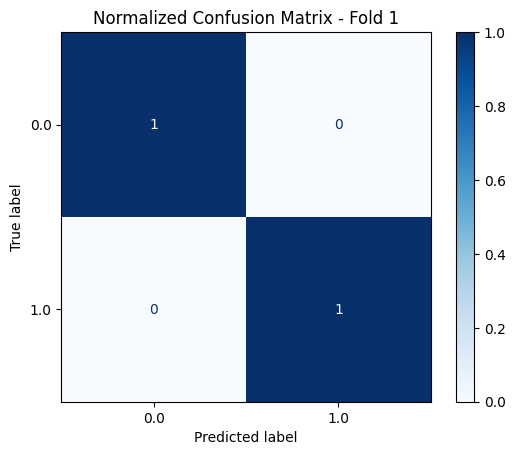

Processing Confusion Matrix for Fold 2


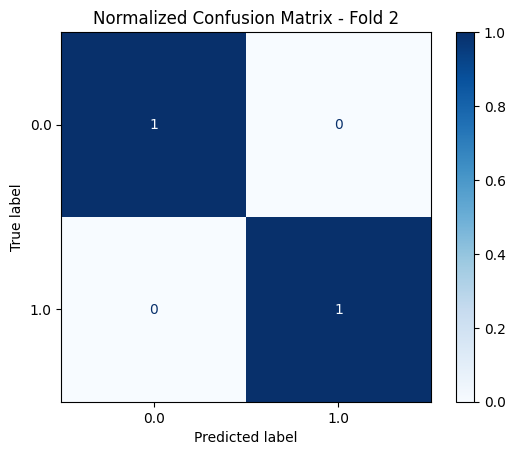

Processing Confusion Matrix for Fold 3


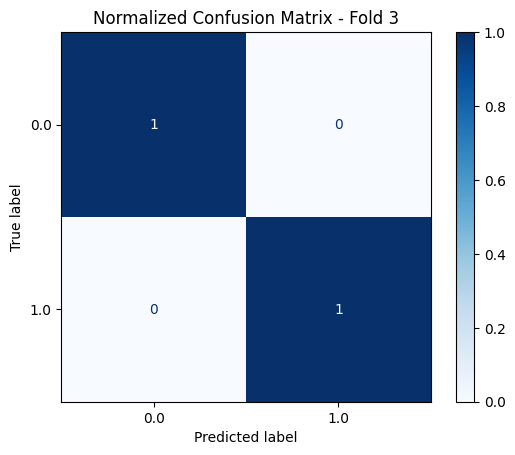

Processing Confusion Matrix for Fold 4


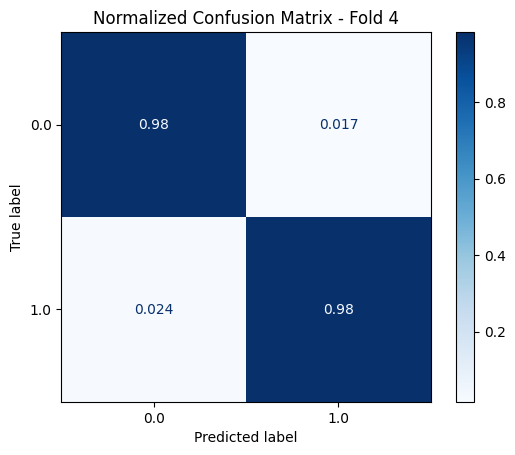

Processing Confusion Matrix for Fold 5


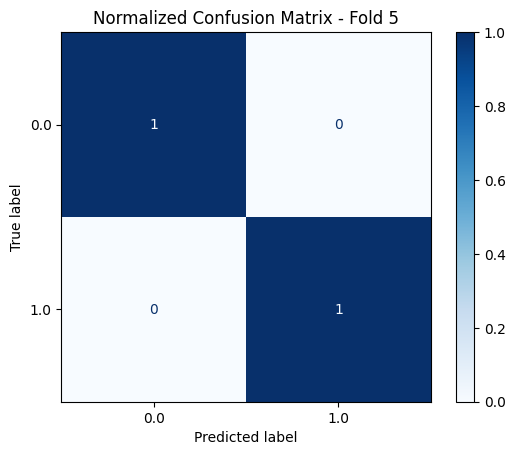

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Shuffle data with random_seed = 42 for reproducibility

for fold, (train_index, test_index) in enumerate(strat_kf.split(combined_df, y_train)):
    print(f"Processing Confusion Matrix for Fold {fold + 1}")

    # Retrieve the SAME test set as before
    test_data = x_train.iloc[test_index]  # File paths for testing set
    test_labels = y_train[test_index]  # Labels for testing set

    # Filter out .DS_Store files (same as before)
    test_data = test_data[~test_data['filepath'].str.endswith('.DS_Store')]

    # Create dataset and dataloader (must match original format)
    test_dataset = ImagesDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load the trained model for this fold
    model = models.densenet121(pretrained=True)  
    model.classifier = nn.Sequential(  # Replace the classifier layer
        nn.Linear(1024, 100),  # Dense layer takes a 1024-dim input and outputs 100-dim
        nn.ReLU(inplace=True),  # ReLU activation
        nn.Dropout(0.1),  # Dropout for regularization
        nn.Linear(100, 1),  # Final layer for 1 class
        nn.Sigmoid()
    )
    model.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pth"))
    model.eval()  

    # Get predictions on the test set
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['image'], batch['label']
            labels = labels.unsqueeze(1).float()
            outputs = model(images)
            
            # For binary classification, get the probabilities for class 1
            #probs = torch.sigmoid(outputs).squeeze()  # Squeeze to remove extra dimensions
            preds = (outputs > 0.5).int()
            test_preds.extend(preds.cpu().numpy())  # Predicted label: 1 if prob > 0.5, else 0
            test_labels.extend(labels.cpu().numpy())  # Get true labels

            #test_outputs.extend(probs.cpu().detach().numpy())  # Get probabilities for the positive class
            #test_probs.extend(outputs.cpu().detach().numpy())  # Store probabilities for AUC calculation


    #test_outputs = np.array(test_probs)
    #test_labels = np.array(test_labels)
    test_labels = np.array(test_labels)
    test_preds = np.array(test_preds)
    #test_probs = np.array(test_probs)
    

    
    # Compute and display the normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, normalize='true', cmap='Blues')
    disp.ax_.set_title(f"Normalized Confusion Matrix - Fold {fold+1}")
    plt.show()



        


### Line Charts for Train Times (1 per Fold)

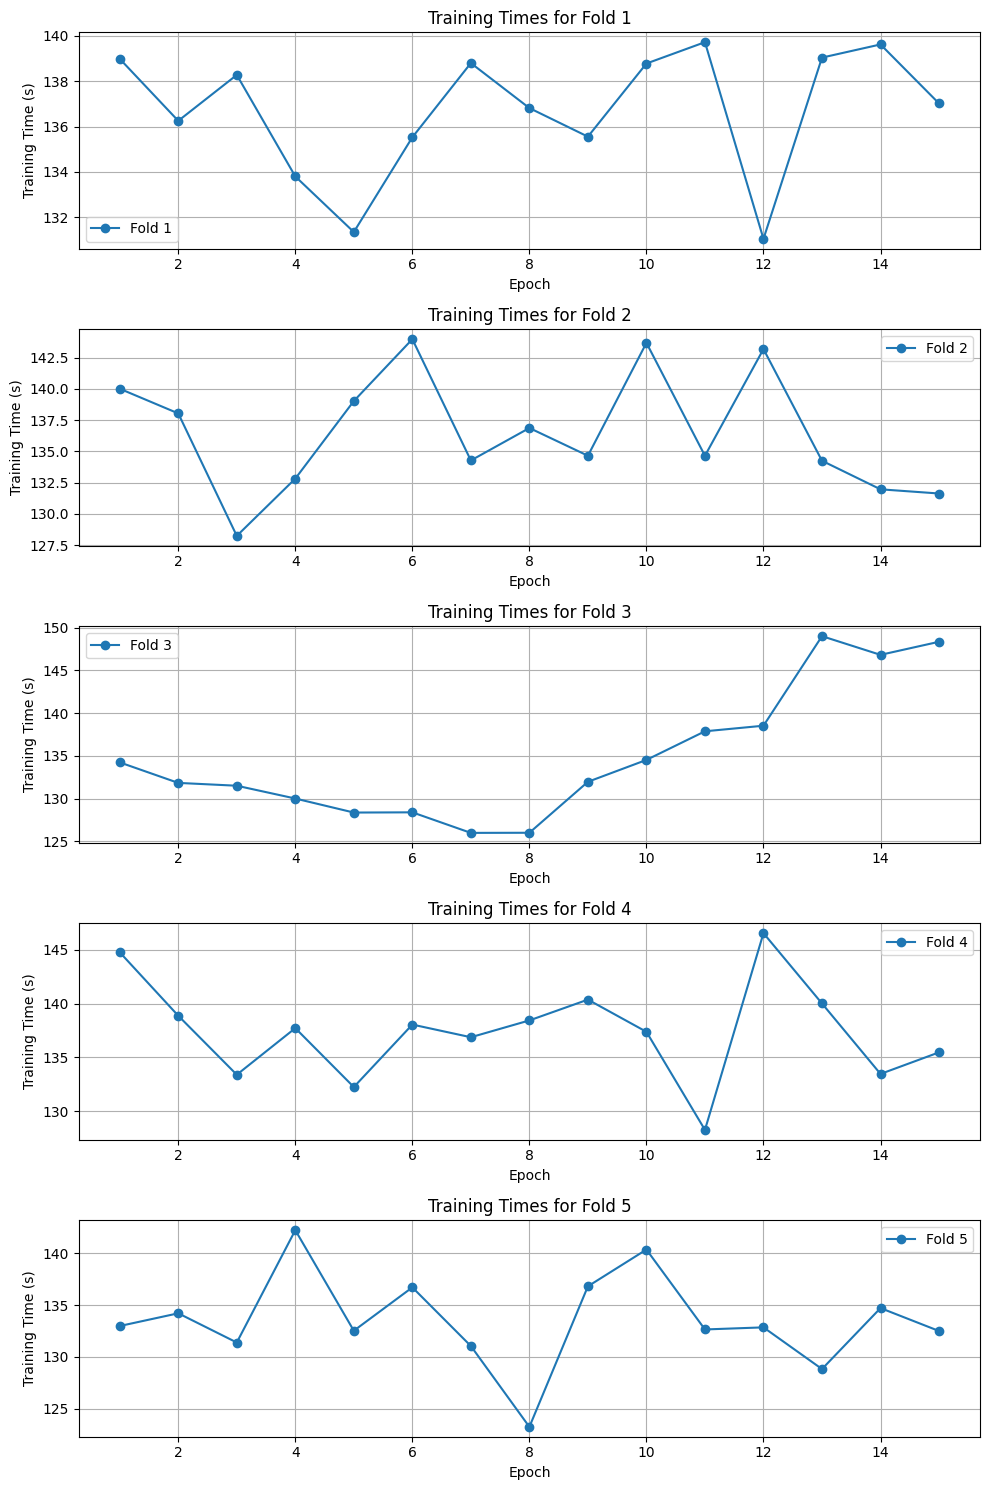

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# Iterate through each fold and plot its training times
for i, fold in enumerate(all_train_times):
    axes[i].plot(range(1, 16), fold, marker='o', label=f'Fold {i+1}')
    axes[i].set_title(f'Training Times for Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Training Time (s)')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Graph Train Loss for Each Fold

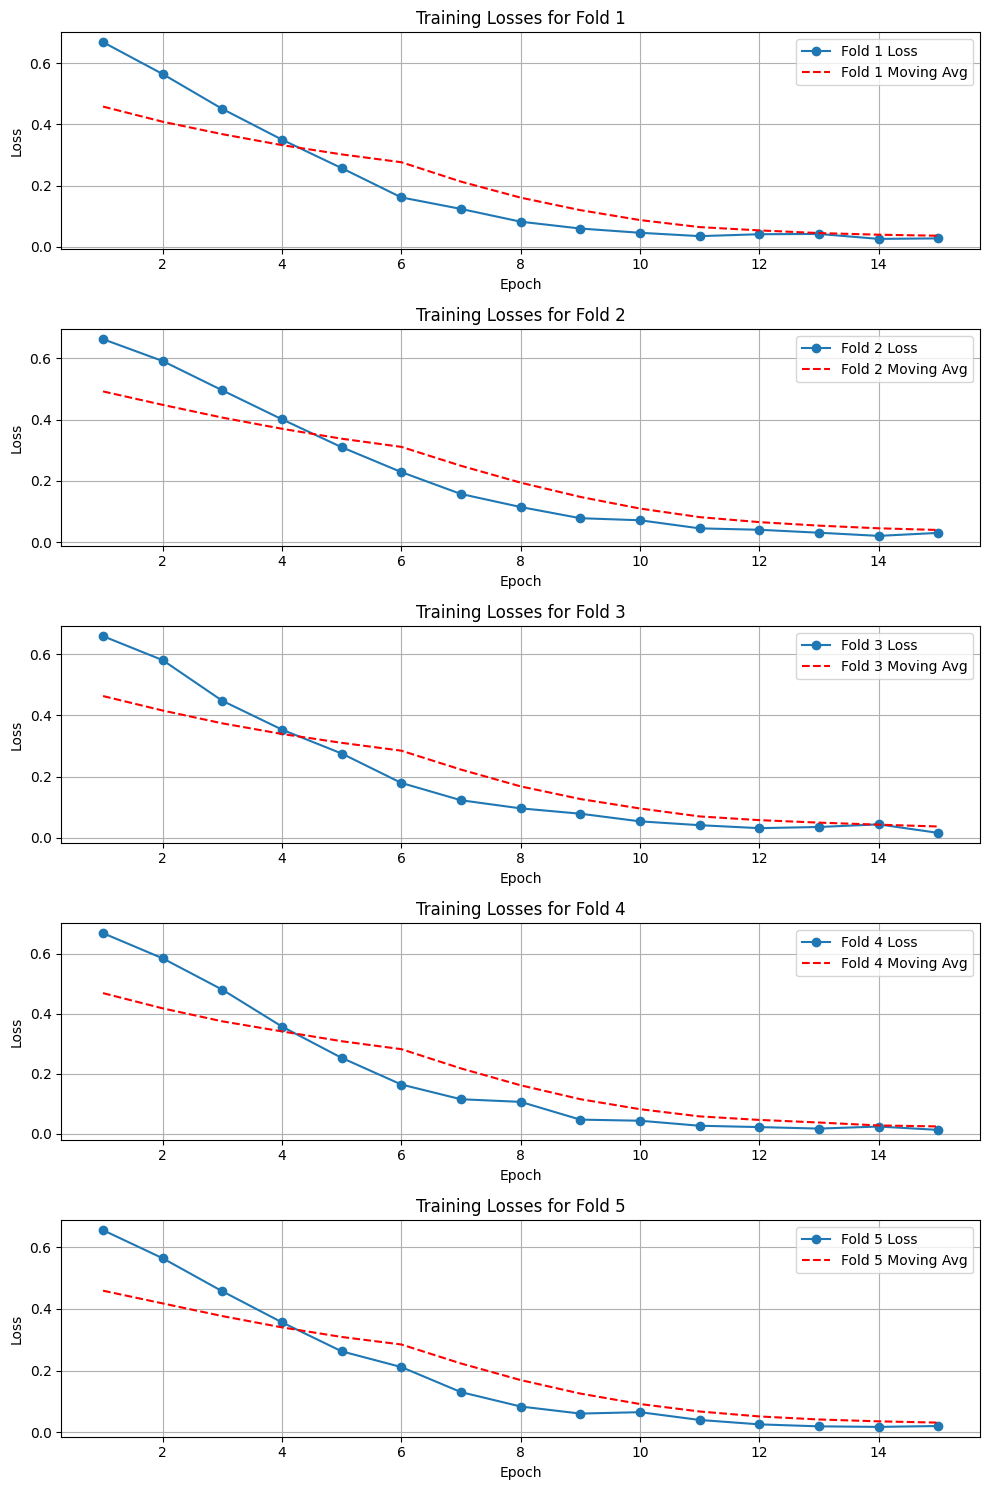

In [14]:

# Create a figure with 5 subplots (one for each fold)
fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# Iterate through each fold and plot its training losses and moving average
for i, fold in enumerate(all_train_losses):
    # Convert the fold's loss values to a pandas Series for rolling mean
    tracking_loss = pd.Series(fold)
    
    # Ensure that the values are floats (necessary for rolling mean calculation)
    tracking_loss = tracking_loss.astype(float)
    
    # Calculate the rolling average with a window size of 10
    rolling_avg = tracking_loss.rolling(center=True, min_periods=1, window=10).mean()
    
    # Plot the original loss values
    axes[i].plot(range(1, len(fold) + 1), fold, marker='o', label=f'Fold {i+1} Loss')
    
    # Plot the moving average (rolling mean)
    axes[i].plot(range(1, len(fold) + 1), rolling_avg, linestyle='--', color='red', label=f'Fold {i+1} Moving Avg')
    
    # Set titles and labels
    axes[i].set_title(f'Training Losses for Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Graph Validation Loss for Each Fold

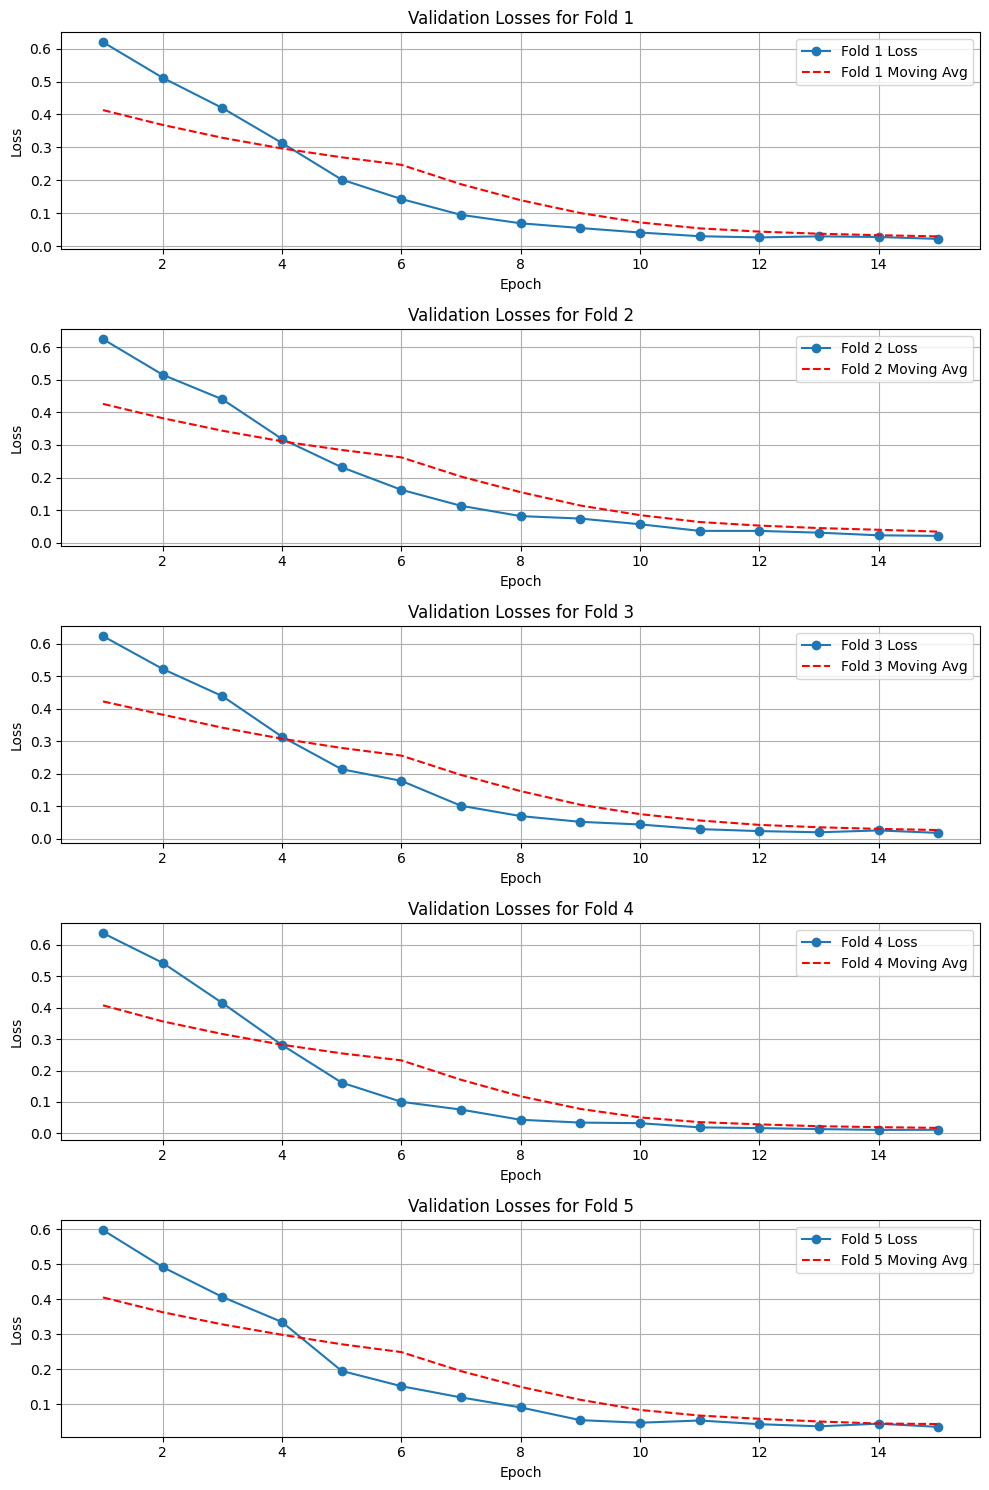

In [15]:
# Create a figure with 5 subplots (one for each fold)
fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# Iterate through each fold and plot its training losses and moving average
for i, fold in enumerate(all_validation_loss):
    # Convert the fold's loss values to a pandas Series for rolling mean
    tracking_loss = pd.Series(fold)
    
    # Ensure that the values are floats (necessary for rolling mean calculation)
    tracking_loss = tracking_loss.astype(float)
    
    # Calculate the rolling average with a window size of 10
    rolling_avg = tracking_loss.rolling(center=True, min_periods=1, window=10).mean()
    
    # Plot the original loss values
    axes[i].plot(range(1, len(fold) + 1), fold, marker='o', label=f'Fold {i+1} Loss')
    
    # Plot the moving average (rolling mean)
    axes[i].plot(range(1, len(fold) + 1), rolling_avg, linestyle='--', color='red', label=f'Fold {i+1} Moving Avg')
    
    # Set titles and labels
    axes[i].set_title(f'Validation Losses for Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

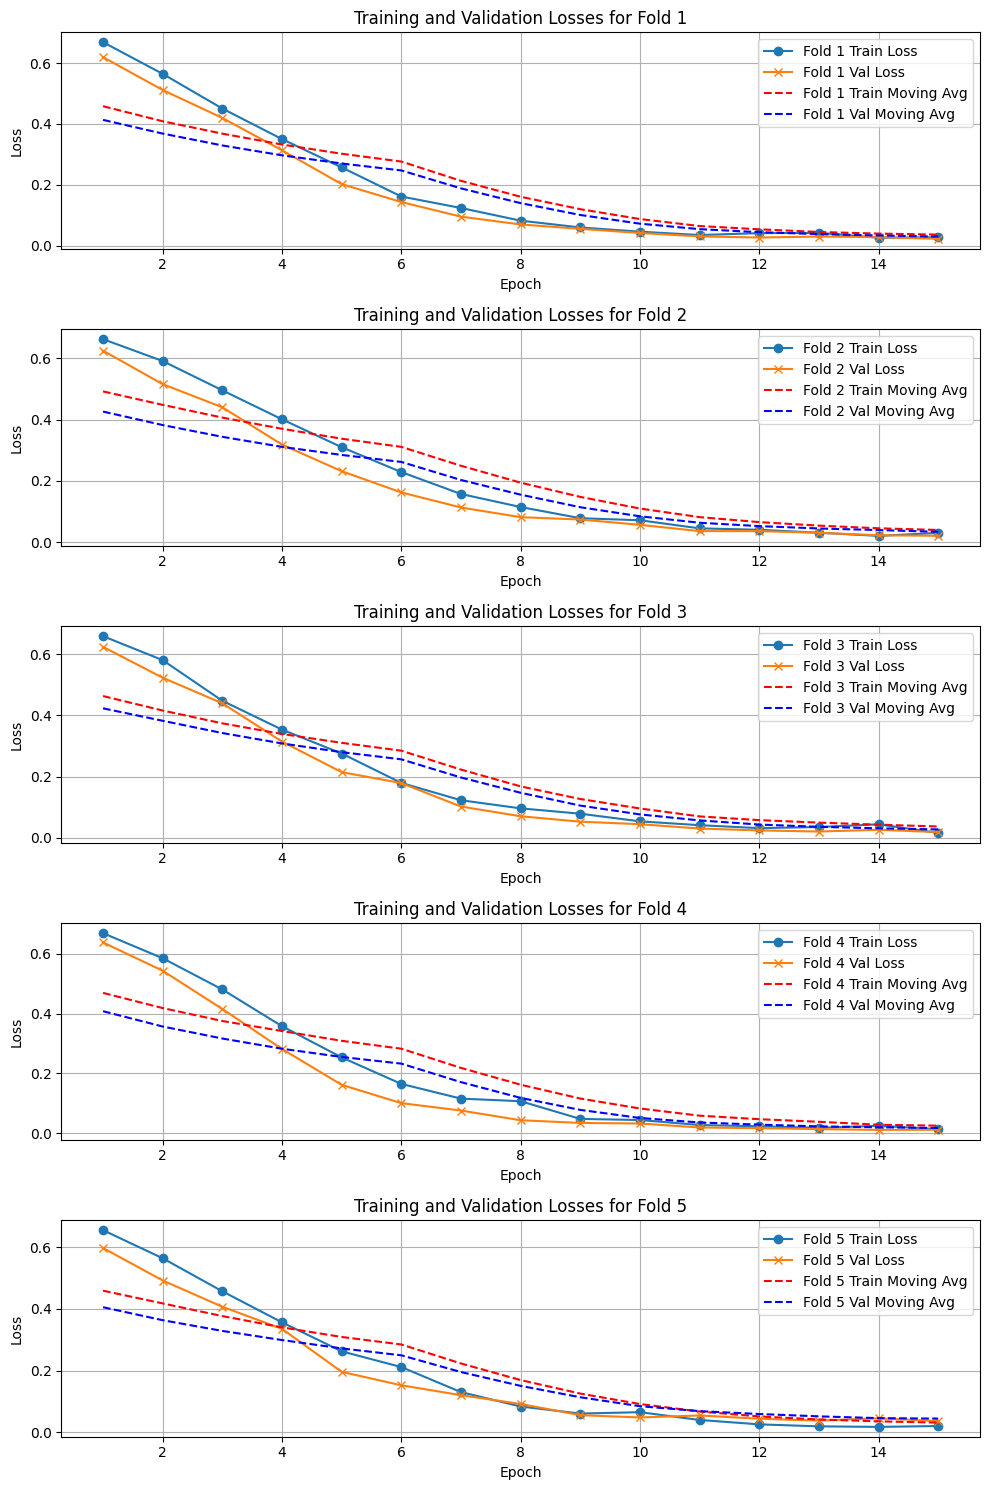

In [16]:
# Create a figure with 5 subplots (one for each fold)
fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# Iterate through each fold and plot both training and validation losses with moving averages
for i, (train_loss, val_loss) in enumerate(zip(all_train_losses, all_validation_loss)):
    # Convert the training and validation loss values to pandas Series for rolling mean
    train_loss_series = pd.Series(train_loss).astype(float)
    val_loss_series = pd.Series(val_loss).astype(float)
    
    # Calculate the rolling average with a window size of 10
    train_rolling_avg = train_loss_series.rolling(center=True, min_periods=1, window=10).mean()
    val_rolling_avg = val_loss_series.rolling(center=True, min_periods=1, window=10).mean()
    
    # Plot the original training and validation losses
    axes[i].plot(range(1, len(train_loss) + 1), train_loss, marker='o', label=f'Fold {i+1} Train Loss')
    axes[i].plot(range(1, len(val_loss) + 1), val_loss, marker='x', label=f'Fold {i+1} Val Loss')
    
    # Plot the moving averages
    axes[i].plot(range(1, len(train_loss) + 1), train_rolling_avg, linestyle='--', color='red', label=f'Fold {i+1} Train Moving Avg')
    axes[i].plot(range(1, len(val_loss) + 1), val_rolling_avg, linestyle='--', color='blue', label=f'Fold {i+1} Val Moving Avg')
    
    # Set titles and labels
    axes[i].set_title(f'Training and Validation Losses for Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Bar Charts for Each Metric for Test Per Species

{'accuracy': [[0.00990099009900991, 0.9900990099009901], [0.04950495049504955, 0.9504950495049505], [0.00990099009900991, 0.9900990099009901], [0.040000000000000036, 0.96], [0.020000000000000018, 0.98]], 'precision': [array([1.        , 0.97674419]), array([0.96610169, 0.92857143]), array([1.        , 0.97619048]), array([0.96610169, 0.95121951]), array([0.98305085, 0.97560976])], 'recall': [array([0.98305085, 1.        ]), array([0.95      , 0.95121951]), array([0.98333333, 1.        ]), array([0.96610169, 0.95121951]), array([0.98305085, 0.97560976])], 'f1': [array([0.99145299, 0.98823529]), array([0.95798319, 0.93975904]), array([0.99159664, 0.98795181]), array([0.96610169, 0.95121951]), array([0.98305085, 0.97560976])], 'auc': [np.float64(0.9995964487489911), np.float64(0.9906504065040651), np.float64(0.9971544715447154), np.float64(0.9966928482844151), np.float64(0.9979330301777595)]}


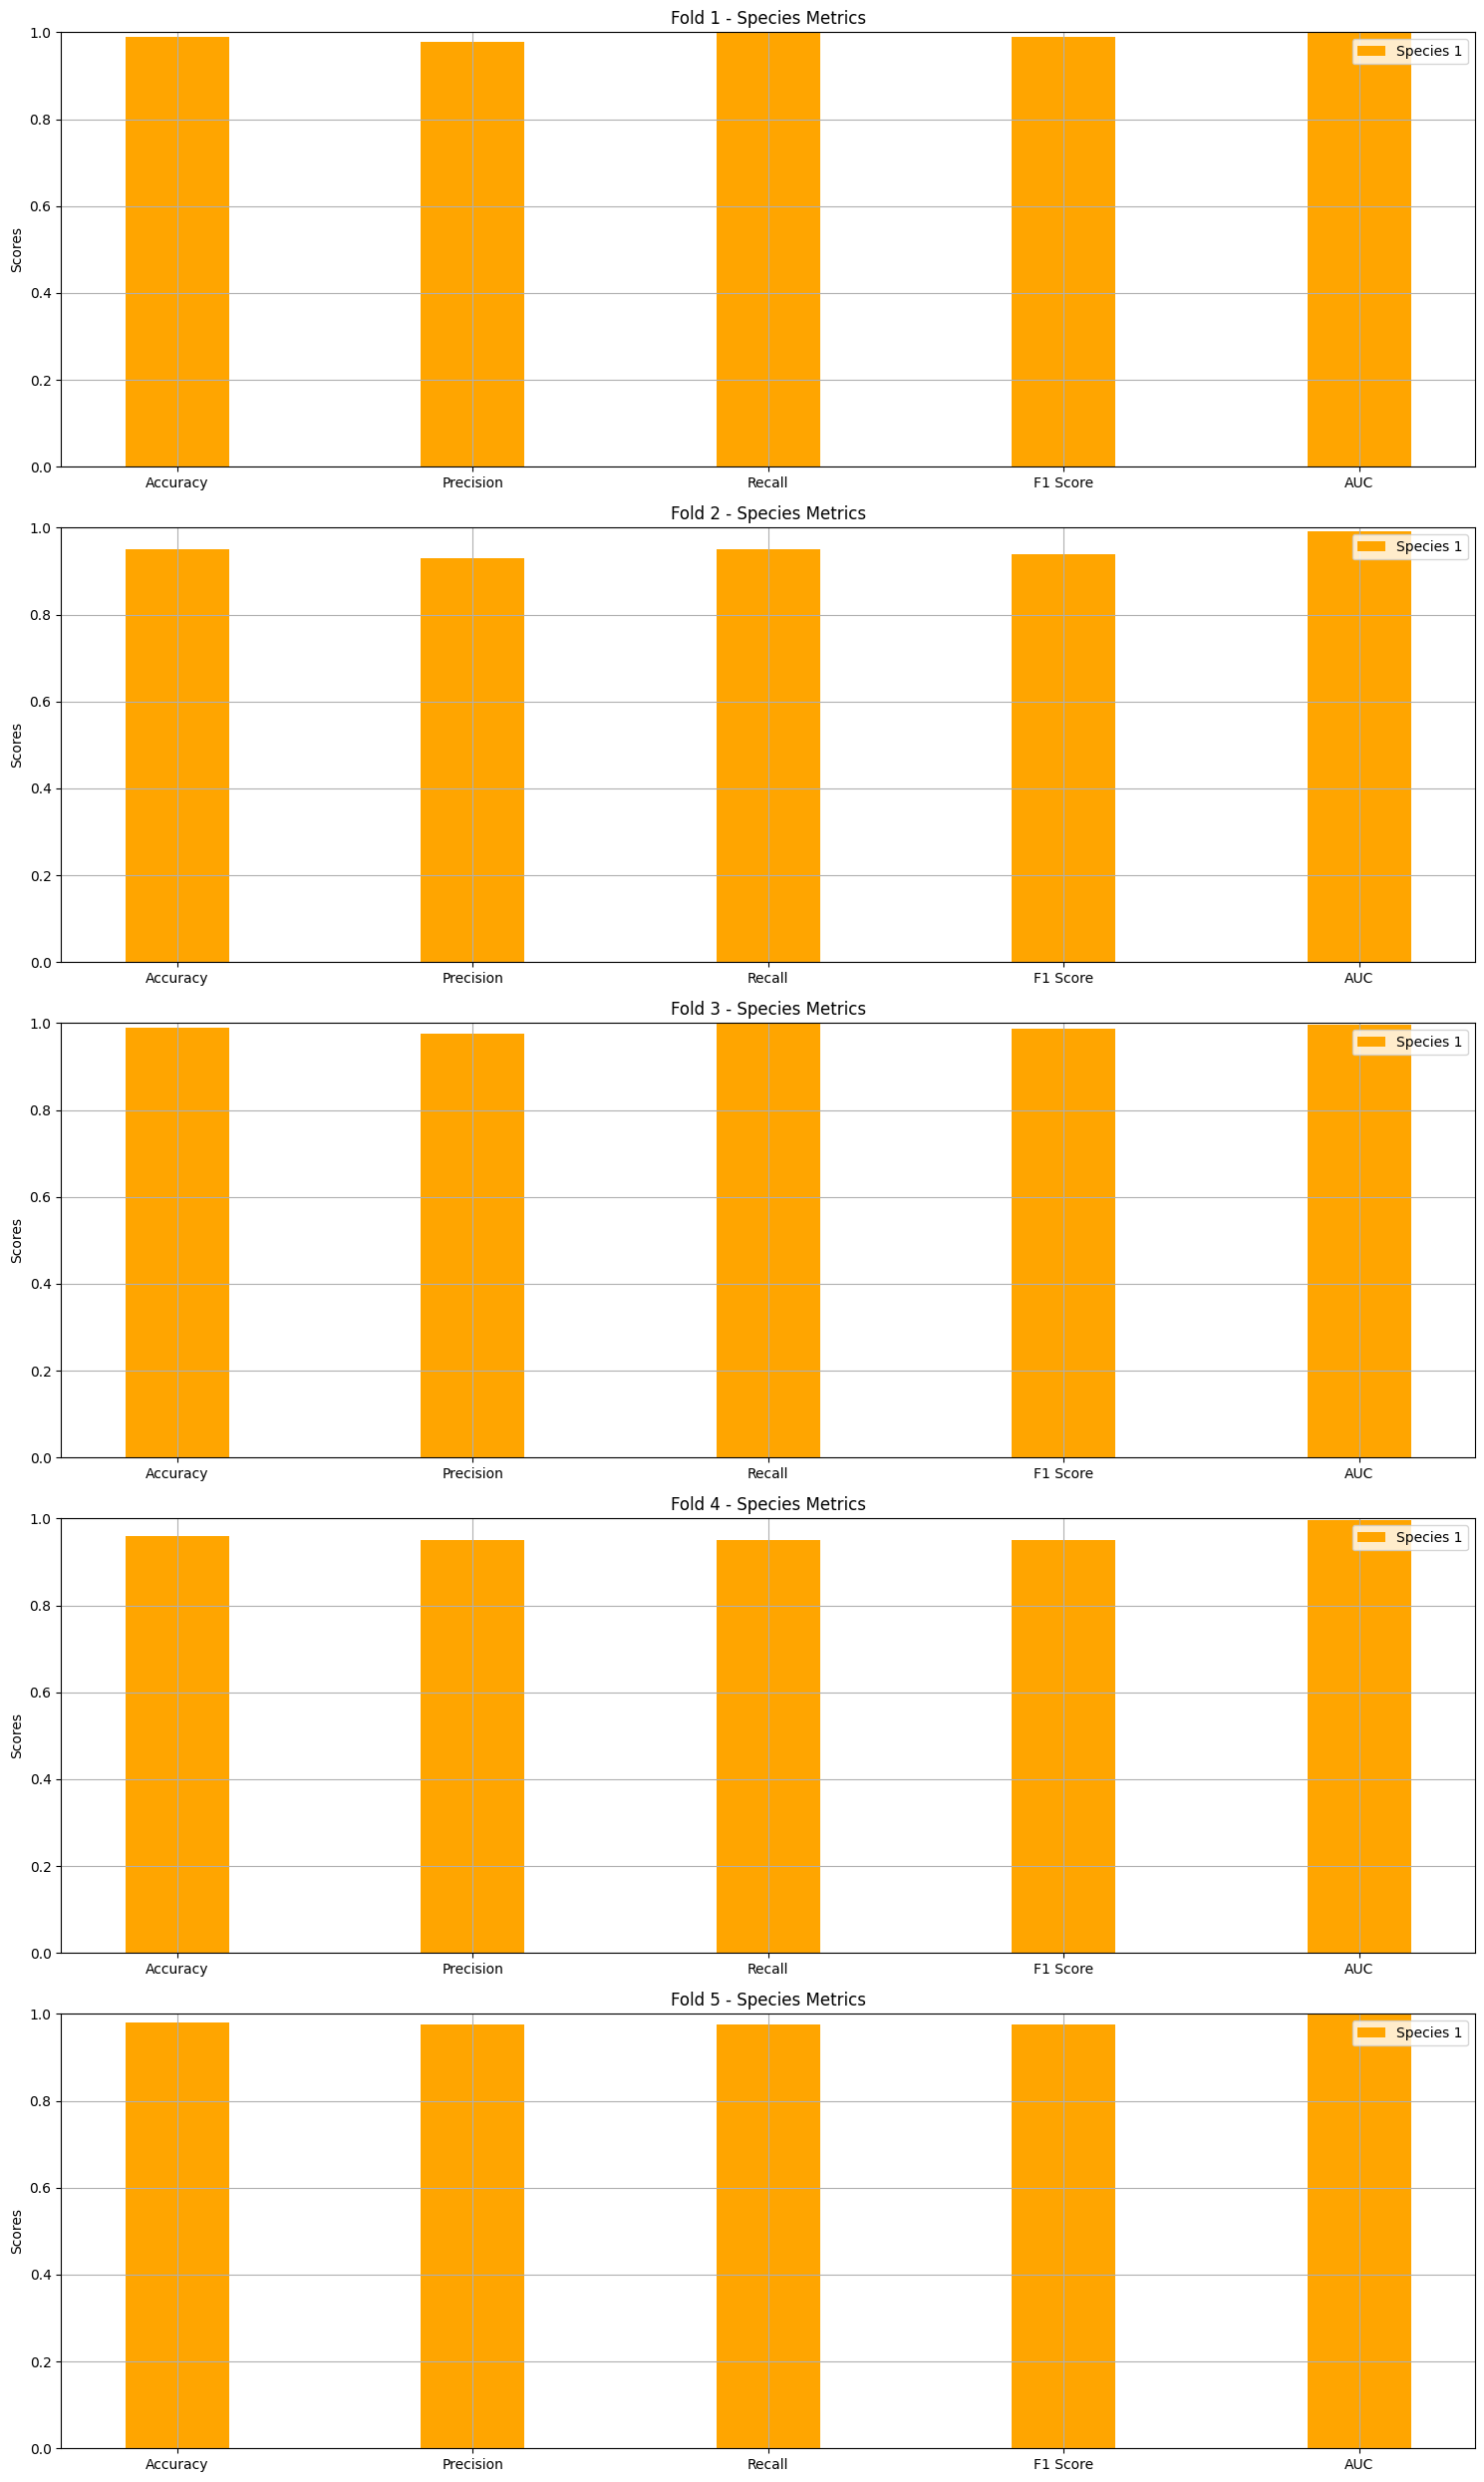


Fold 1 Metrics:
Accuracy: 0.9901, Precision: 0.9767, Recall: 1.0000, F1 Score: 0.9882, AUC: 0.9996

Fold 2 Metrics:
Accuracy: 0.9505, Precision: 0.9286, Recall: 0.9512, F1 Score: 0.9398, AUC: 0.9907

Fold 3 Metrics:
Accuracy: 0.9901, Precision: 0.9762, Recall: 1.0000, F1 Score: 0.9880, AUC: 0.9972

Fold 4 Metrics:
Accuracy: 0.9600, Precision: 0.9512, Recall: 0.9512, F1 Score: 0.9512, AUC: 0.9967

Fold 5 Metrics:
Accuracy: 0.9800, Precision: 0.9756, Recall: 0.9756, F1 Score: 0.9756, AUC: 0.9979


In [32]:
import matplotlib.pyplot as plt
import numpy as np

print(all_per_species_test_metrics)

# Number of metrics per fold (Accuracy, Precision, Recall, F1, AUC)
num_metrics = 5

# X positions for each metric group
x = np.arange(num_metrics)  # No need for species-based indexing

# Bar width
width = 0.35

# Create subplots for each fold (one bar chart with all metrics)
fig, axes = plt.subplots(5, figsize=(15, 5 * 5))

# Metric labels
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Iterate over each fold to create the bar charts
for fold in range(5):
    # Extract per-species metrics for this fold
    species_1_accuracy = all_per_species_test_metrics['accuracy'][fold][1]
    species_1_precision = all_per_species_test_metrics['precision'][fold][1]
    species_1_recall = all_per_species_test_metrics['recall'][fold][1]
    species_1_f1 = all_per_species_test_metrics['f1'][fold][1]
    species_1_auc = all_test_metrics['auc'][fold]

    # Create the bars for this fold (only Species 1)
    axes[fold].bar(x, [species_1_accuracy, species_1_precision, species_1_recall, species_1_f1, species_1_auc],
                   width, label='Species 1', color='orange')

    axes[fold].set_title(f"Fold {fold + 1} - Species Metrics")
    axes[fold].set_xticks(x)
    axes[fold].set_xticklabels(metric_labels)
    axes[fold].set_ylabel('Scores')
    axes[fold].set_ylim(0, 1)  # Ensuring y-axis ranges from 0 to 1 for metric comparison
    axes[fold].legend()
    axes[fold].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print only Species 1 metrics per fold
for fold in range(5):
    print(f"\nFold {fold + 1} Metrics:")
    print(f"Accuracy: {all_per_species_test_metrics['accuracy'][fold][1]:.4f}, "
          f"Precision: {all_per_species_test_metrics['precision'][fold][1]:.4f}, "
          f"Recall: {all_per_species_test_metrics['recall'][fold][1]:.4f}, "
          f"F1 Score: {all_per_species_test_metrics['f1'][fold][1]:.4f}, "
          f"AUC: {all_test_metrics['auc'][fold]:.4f}")


### Average Over All Test Metrics Per Species

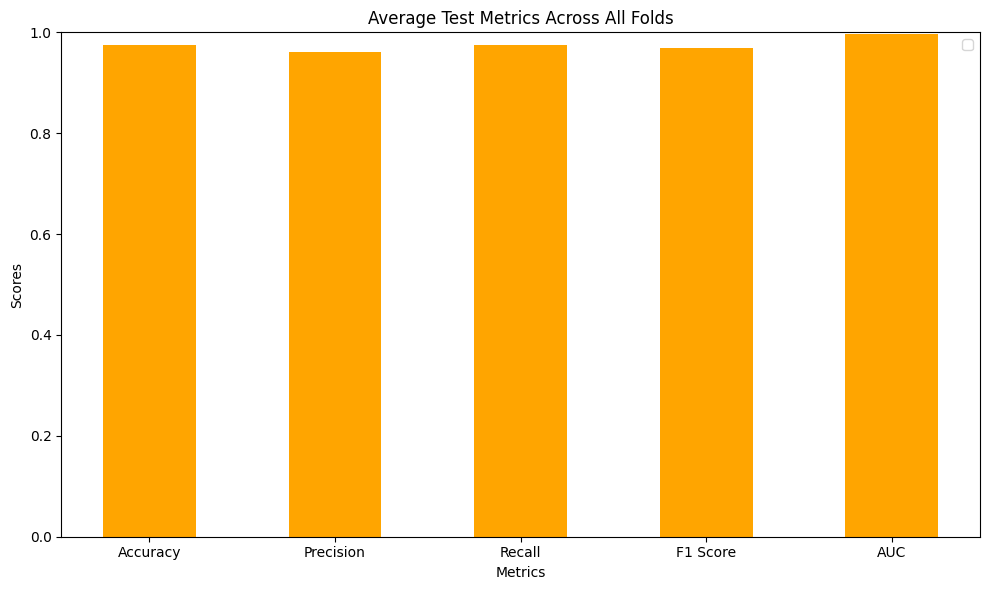

Average Test Metrics Across All Folds:
Accuracy: 0.9741, Precision: 0.9617, Recall: 0.9756, F1 Score: 0.9686, AUC: 0.9964


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Metric labels
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Calculate the average values for each metric across all folds (only Species 1)
avg_accuracy_species_1 = np.mean([metrics[1] for metrics in all_per_species_test_metrics['accuracy']])
avg_precision_species_1 = np.mean([metrics[1] for metrics in all_per_species_test_metrics['precision']])
avg_recall_species_1 = np.mean([metrics[1] for metrics in all_per_species_test_metrics['recall']])
avg_f1_species_1 = np.mean([metrics[1] for metrics in all_per_species_test_metrics['f1']])
avg_auc_species_1 = np.mean(all_test_metrics['auc'])

# Create a bar chart for Species 1
x = np.arange(len(metric_labels))  # X positions for each metric
width = 0.5  # Adjusted bar width since we're only plotting one species

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, [avg_accuracy_species_1, avg_precision_species_1, avg_recall_species_1, avg_f1_species_1, avg_auc_species_1],
       width, color='orange')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Average Test Metrics Across All Folds')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0, 1)  # y-axis range from 0 to 1 for comparison
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Print the average test metrics (only Species 1)
print("Average Test Metrics Across All Folds:")
print(f"Accuracy: {avg_accuracy_species_1:.4f}, Precision: {avg_precision_species_1:.4f}, "
      f"Recall: {avg_recall_species_1:.4f}, F1 Score: {avg_f1_species_1:.4f}, AUC: {avg_auc_species_1:.4f}")


### Average Overall Across All Folds for Test Metrics

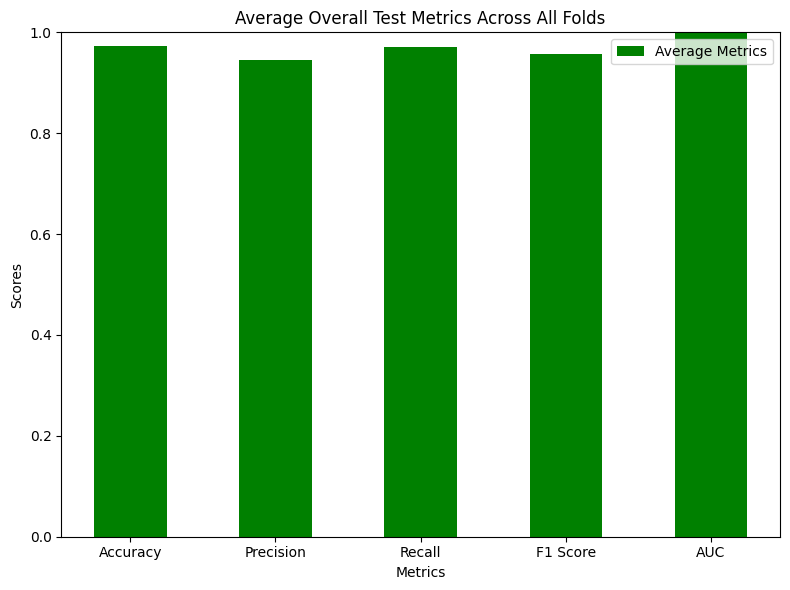

Average Overall Test Metrics Across All Folds:
Accuracy: 0.9724
Precision: 0.9455
Recall: 0.9707
F1 Score: 0.9567
AUC: 0.9989


In [40]:
# Calculate the average values for each metric across all folds
avg_accuracy = np.mean(all_test_metrics['accuracy'])
avg_precision = np.mean(all_test_metrics['precision'])
avg_recall = np.mean(all_test_metrics['recall'])
avg_f1 = np.mean(all_test_metrics['f1'])
avg_auc = np.mean(all_test_metrics['auc'])

# Create a bar chart to display the average values
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
avg_metrics = [avg_accuracy, avg_precision, avg_recall, avg_f1, avg_auc]

x = np.arange(len(metric_labels))  # x positions for each metric
width = 0.5  # Bar width

# Plot the averages for overall metrics
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, avg_metrics, width, color='green', label='Average Metrics')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Average Overall Test Metrics Across All Folds')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0, 1)  # y-axis range from 0 to 1 for comparison
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Print the average overall test metrics
print("Average Overall Test Metrics Across All Folds:")
print(f"Accuracy: {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1 Score: {avg_f1:.4f}")
print(f"AUC: {avg_auc:.4f}")

### Overall Per Fold for Test

Fold 1:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  AUC       : 1.0000

Fold 2:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  AUC       : 1.0000

Fold 3:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  AUC       : 1.0000

Fold 4:
  Accuracy  : 0.9692
  Precision : 0.9707
  Recall    : 0.9578
  F1 Score  : 0.9639
  AUC       : 0.9973

Fold 5:
  Accuracy  : 0.9615
  Precision : 0.9583
  Recall    : 0.9522
  F1 Score  : 0.9552
  AUC       : 0.9951



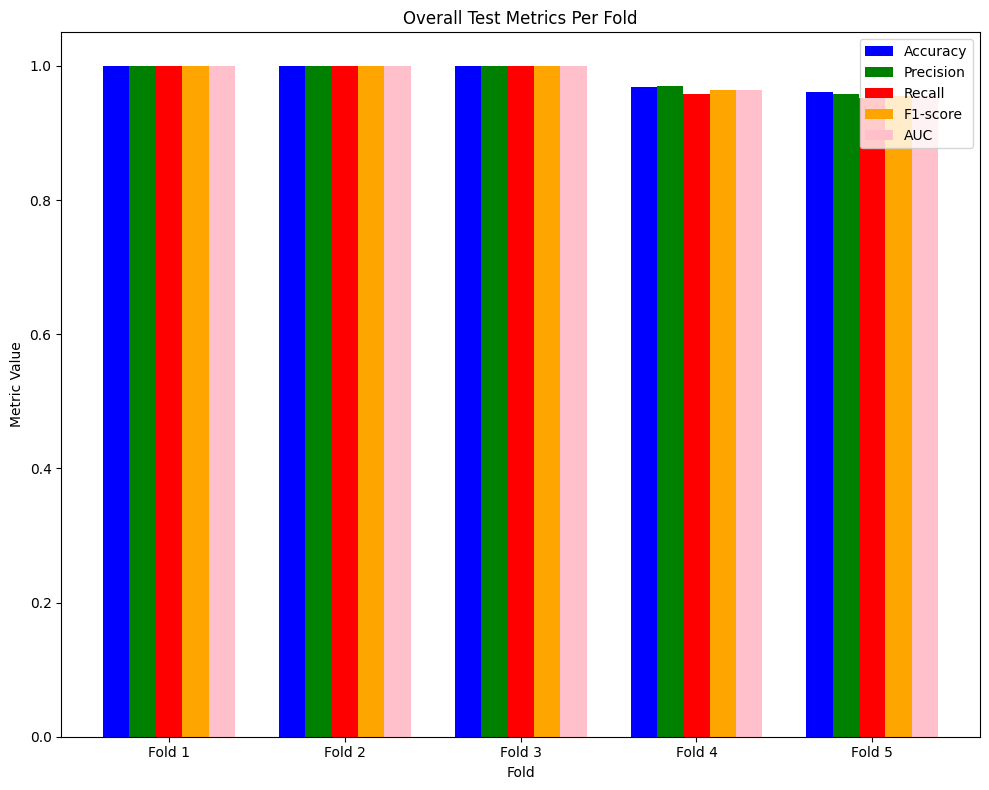

In [100]:
# Set up positions for the bars
folds = range(1, len(all_test_metrics['accuracy']) + 1)

# Set up the bar width
width = 0.15

# Create a figure
plt.figure(figsize=(10, 8))

# Plot one bar chart per fold
for fold in range(len(folds)):
    # Get the metrics for the current fold
    accuracy = all_test_metrics['accuracy'][fold]
    precision = all_test_metrics['precision'][fold]
    recall = all_test_metrics['recall'][fold]
    f1 = all_test_metrics['f1'][fold]
    auc = all_test_metrics['auc'][fold]

    # Print the metrics for this fold
    print(f"Fold {fold + 1}:")
    print(f"  Accuracy  : {accuracy:.4f}")
    print(f"  Precision : {precision:.4f}")
    print(f"  Recall    : {recall:.4f}")
    print(f"  F1 Score  : {f1:.4f}")
    print(f"  AUC       : {auc:.4f}\n")
    
    # Set x positions for the bars
    bar_positions = np.array([fold + 1 - 2 * width, fold + 1 - width, fold + 1, fold + 1 + width, fold + 1 + 2 * width])
    
    # Plot bars for the current fold
    plt.bar(bar_positions[0], accuracy, width, label='Accuracy' if fold == 0 else "", color='b')
    plt.bar(bar_positions[1], precision, width, label='Precision' if fold == 0 else "", color='g')
    plt.bar(bar_positions[2], recall, width, label='Recall' if fold == 0 else "", color='r')
    plt.bar(bar_positions[3], f1, width, label='F1-score' if fold == 0 else "", color='orange')
    plt.bar(bar_positions[4], f1, width, label='AUC' if fold == 0 else "", color='pink')

# Labeling the graph
plt.title('Overall Test Metrics Per Fold')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(folds, [f'Fold {i}' for i in folds])

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Which Images Did Test Get Wrong?

Processing Confusion Matrix for Fold 1


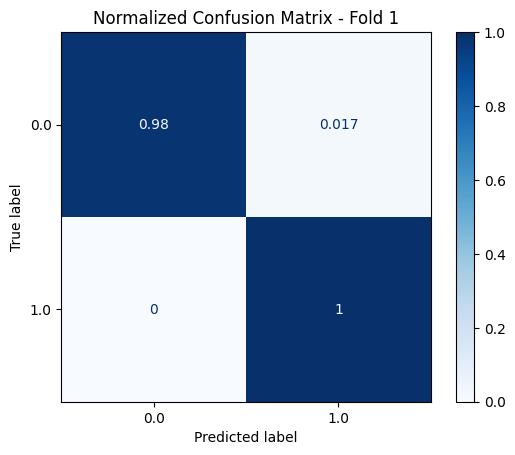

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1015.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


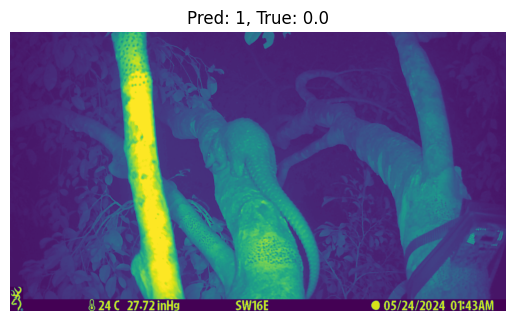

Processing Confusion Matrix for Fold 2


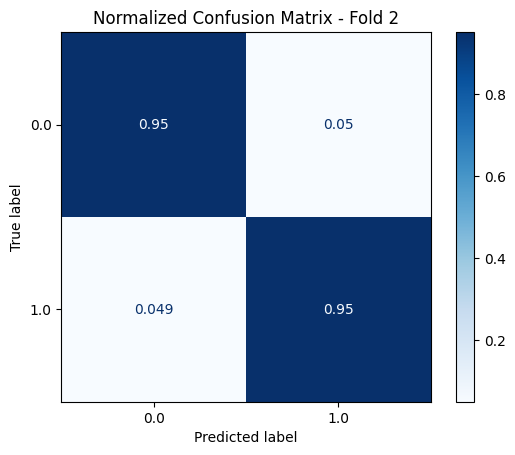

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1097.JPG
Predicted Label: tensor([0], dtype=torch.int32), True Label: 1.0


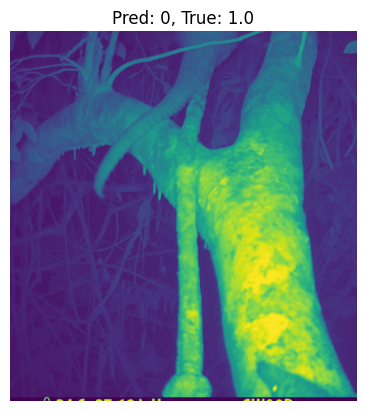

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1178.JPG
Predicted Label: tensor([0], dtype=torch.int32), True Label: 1.0


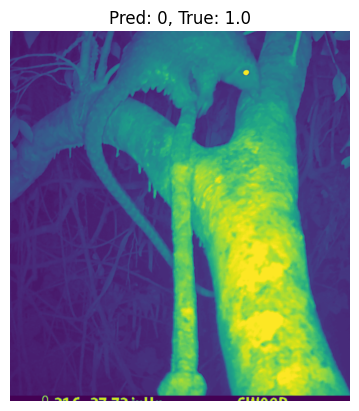

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1168.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


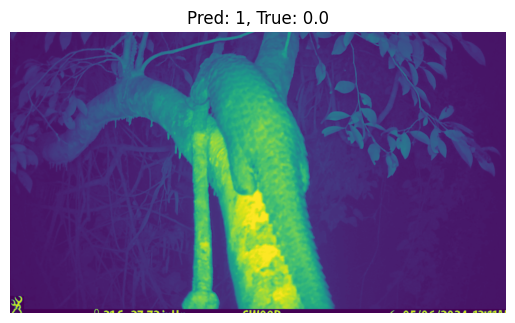

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1192.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


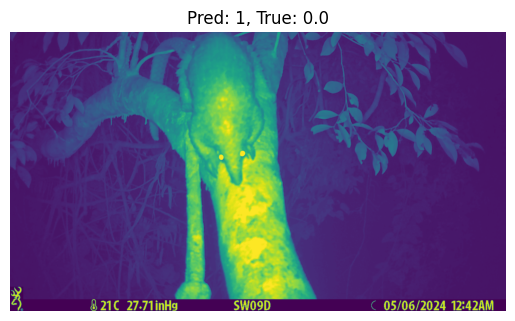

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1019.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


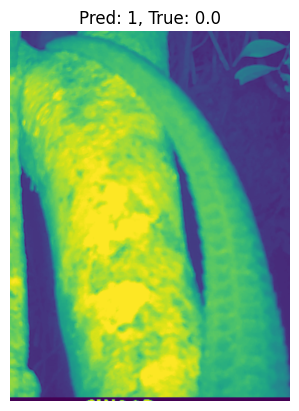

Processing Confusion Matrix for Fold 3


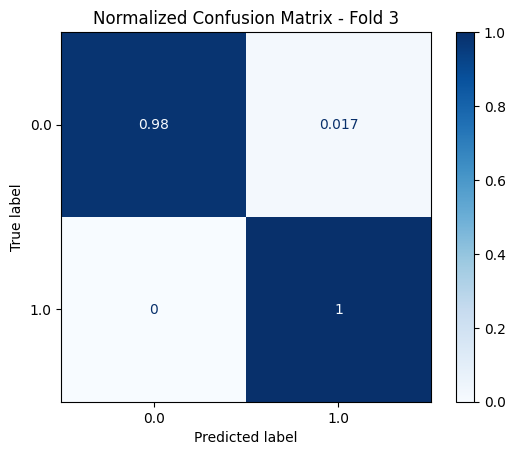

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1040.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


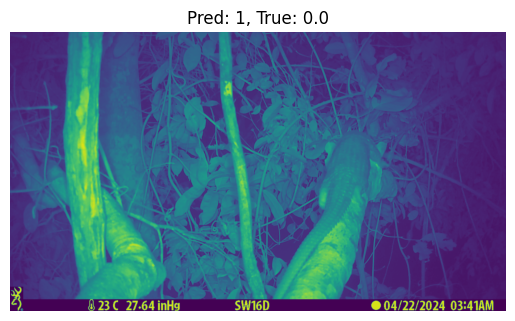

Processing Confusion Matrix for Fold 4


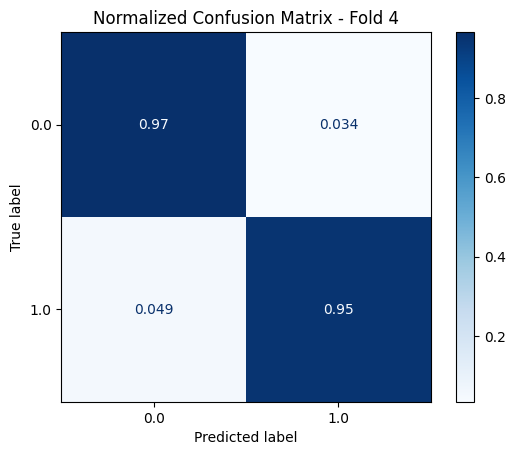

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1179.JPG
Predicted Label: tensor([0], dtype=torch.int32), True Label: 1.0


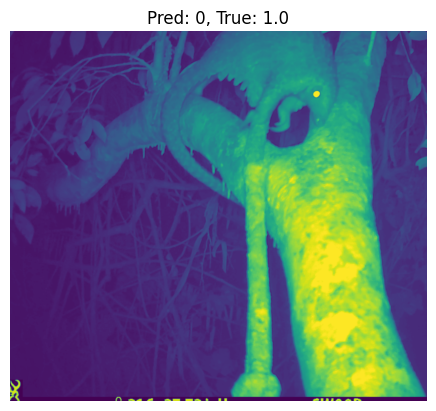

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1285.JPG
Predicted Label: tensor([0], dtype=torch.int32), True Label: 1.0


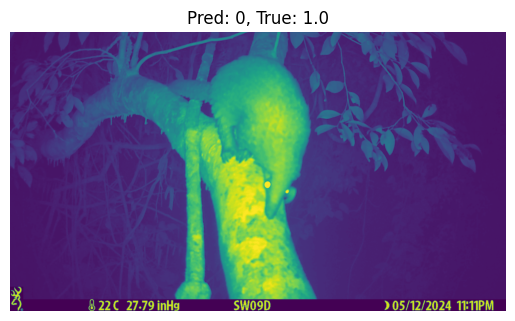

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1613.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


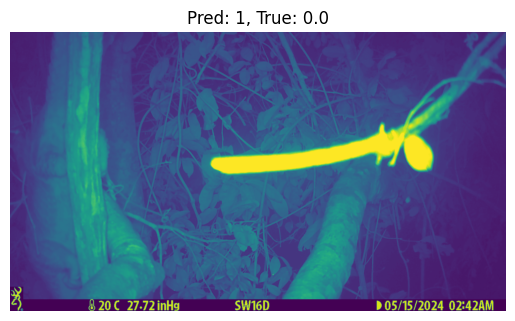

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_1190.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


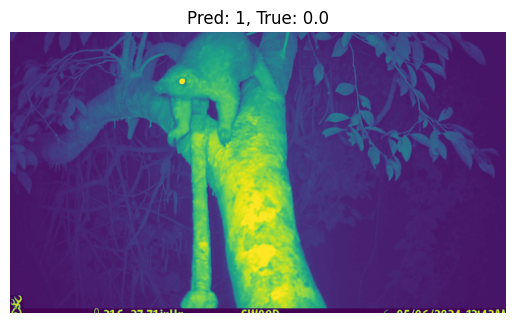

Processing Confusion Matrix for Fold 5


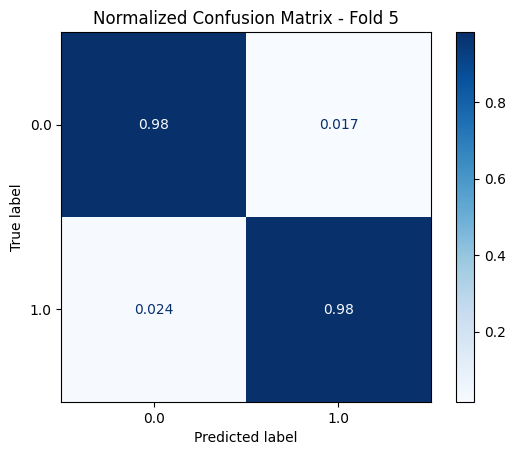

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_0598.JPG
Predicted Label: tensor([0], dtype=torch.int32), True Label: 1.0


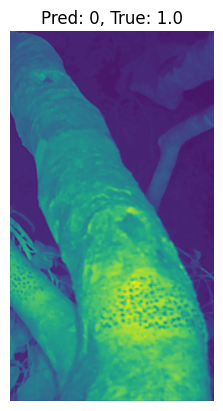

Misclassified Image: Pangolin_Images_3_12_Preprocessed/IMG_0251.JPG
Predicted Label: tensor([1], dtype=torch.int32), True Label: 0.0


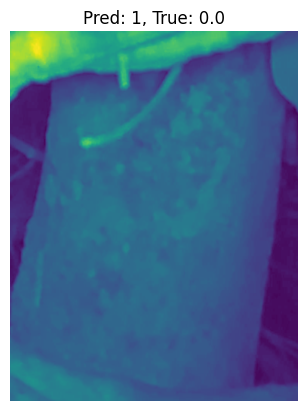

In [33]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image



strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Shuffle data with random_seed = 42 for reproducibility

for fold, (train_index, test_index) in enumerate(strat_kf.split(combined_df, y_train)):
    print(f"Processing Confusion Matrix for Fold {fold + 1}")

    # Retrieve the SAME test set as before
    test_data = x_train.iloc[test_index]  # File paths for testing set
    test_labels = y_train[test_index]  # Labels for testing set

    # Filter out .DS_Store files (same as before)
    test_data = test_data[~test_data['filepath'].str.endswith('.DS_Store')]

    # Create dataset and dataloader (must match original format)
    test_dataset = ImagesDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load the trained model for this fold
    model = models.densenet121(pretrained=True)  
    model.classifier = nn.Sequential(  # Replace the classifier layer
        nn.Linear(1024, 100),  # Dense layer takes a 1024-dim input and outputs 100-dim
        nn.ReLU(inplace=True),  # ReLU activation
        nn.Dropout(0.1),  # Dropout for regularization
        nn.Linear(100, 1),  # Final layer for 1 class
        nn.Sigmoid()
    )
    model.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pth"))
    model.eval()  

    # Get predictions on the test set
    test_preds, test_labels = [], []
    misclassified_images = []  # To store misclassified images and their predictions
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['image'], batch['label']
            labels = labels.unsqueeze(1).float()
            outputs = model(images)
            
            # For binary classification, get the probabilities for class 1
            #probs = torch.sigmoid(outputs).squeeze()  # Squeeze to remove extra dimensions
            preds = (outputs > 0.5).int()
            test_preds.extend(preds.cpu().numpy())  # Predicted label: 1 if prob > 0.5, else 0
            test_labels.extend(labels.cpu().numpy())  # Get true labels

            # Check for misclassified samples
            for i in range(len(preds)):
                if preds[i] != labels[i].item():  # If prediction is incorrect
                    misclassified_images.append((test_data.iloc[i]['filepath'], preds[i], labels[i].item(), images[i]))

            #test_outputs.extend(probs.cpu().detach().numpy())  # Get probabilities for the positive class
            #test_probs.extend(outputs.cpu().detach().numpy())  # Store probabilities for AUC calculation


    #test_outputs = np.array(test_probs)
    #test_labels = np.array(test_labels)
    test_labels = np.array(test_labels)
    test_preds = np.array(test_preds)
    #test_probs = np.array(test_probs)
    

    
    # Compute and display the normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, normalize='true', cmap='Blues')
    disp.ax_.set_title(f"Normalized Confusion Matrix - Fold {fold+1}")
    plt.show()

    # Now print out the misclassified images
    for file_path, pred, true_label, image in misclassified_images:
        print(f"Misclassified Image: {file_path}")
        print(f"Predicted Label: {pred}, True Label: {true_label}")

        # Load and display the image
        img = Image.open(file_path)
        plt.imshow(img)
        plt.title(f"Pred: {pred.item()}, True: {true_label}")
        plt.axis('off')  # Turn off axis labels
        plt.show()



        



In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
from collections import Counter

# Assume strat_kf, combined_df, x_train, and y_train are already defined
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(strat_kf.split(combined_df, y_train)):  # Stratified split
    print(f"Fold {fold+1}/{5}")

    # Split data
    train_data = x_train.iloc[train_index]  # File paths for training set
    test_data = x_train.iloc[test_index]  # File paths for testing set
    train_labels = y_train[train_index]  # Labels for training set
    test_labels = y_train[test_index]  # Labels for testing set

    #print(f"Test indices (Fold {fold+1}): {test_index.tolist()}")

    # Further split the training data into training and validation (90/10 split)
    train_data, val_data, train_labels, val_labels, train_idx, val_idx = train_test_split(
        train_data, train_labels,  # Original training data and labels
        train_index,  # Pass train_index to track indices
        test_size=0.1,  # 10% of train_data becomes val_data
        stratify=train_labels,  # Ensures class proportions are preserved
        random_state=42  # For reproducibility
    )

    #print(f"Train indices (Fold {fold+1}): {train_idx.tolist()}")
    #print(f"Validation indices (Fold {fold+1}): {val_idx.tolist()}")
    
    print(f"Train size: {len(train_idx)}, Validation size: {len(val_idx)}, Test size: {len(test_index)}")

    # Print label distributions
    print(f"Train label counts (Fold {fold+1}): {dict(Counter(train_labels))}")
    print(f"Validation label counts (Fold {fold+1}): {dict(Counter(val_labels))}")
    print(f"Test label counts (Fold {fold+1}): {dict(Counter(test_labels))}")
    print("\n")


    

Fold 1/5
Train size: 469, Validation size: 53, Test size: 131
Train label counts (Fold 1): {np.int64(0): 322, np.int64(1): 147}
Validation label counts (Fold 1): {np.int64(0): 36, np.int64(1): 17}
Test label counts (Fold 1): {np.int64(1): 42, np.int64(0): 89}


Fold 2/5
Train size: 469, Validation size: 53, Test size: 131
Train label counts (Fold 2): {np.int64(0): 321, np.int64(1): 148}
Validation label counts (Fold 2): {np.int64(0): 36, np.int64(1): 17}
Test label counts (Fold 2): {np.int64(1): 41, np.int64(0): 90}


Fold 3/5
Train size: 469, Validation size: 53, Test size: 131
Train label counts (Fold 3): {np.int64(0): 321, np.int64(1): 148}
Validation label counts (Fold 3): {np.int64(0): 36, np.int64(1): 17}
Test label counts (Fold 3): {np.int64(1): 41, np.int64(0): 90}


Fold 4/5
Train size: 470, Validation size: 53, Test size: 130
Train label counts (Fold 4): {np.int64(0): 322, np.int64(1): 148}
Validation label counts (Fold 4): {np.int64(0): 36, np.int64(1): 17}
Test label counts

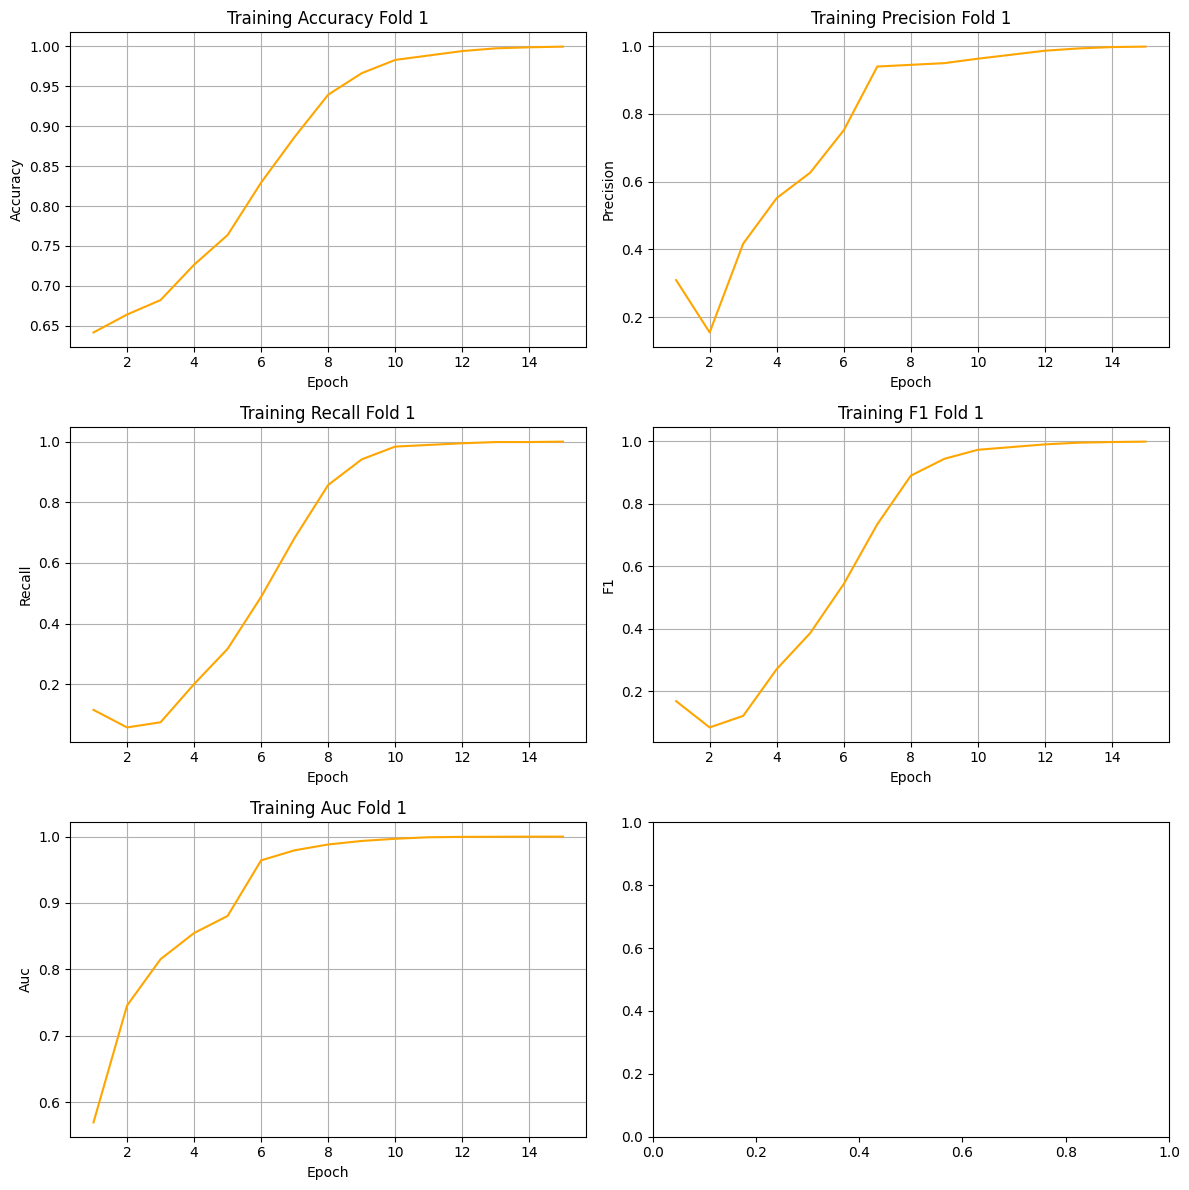

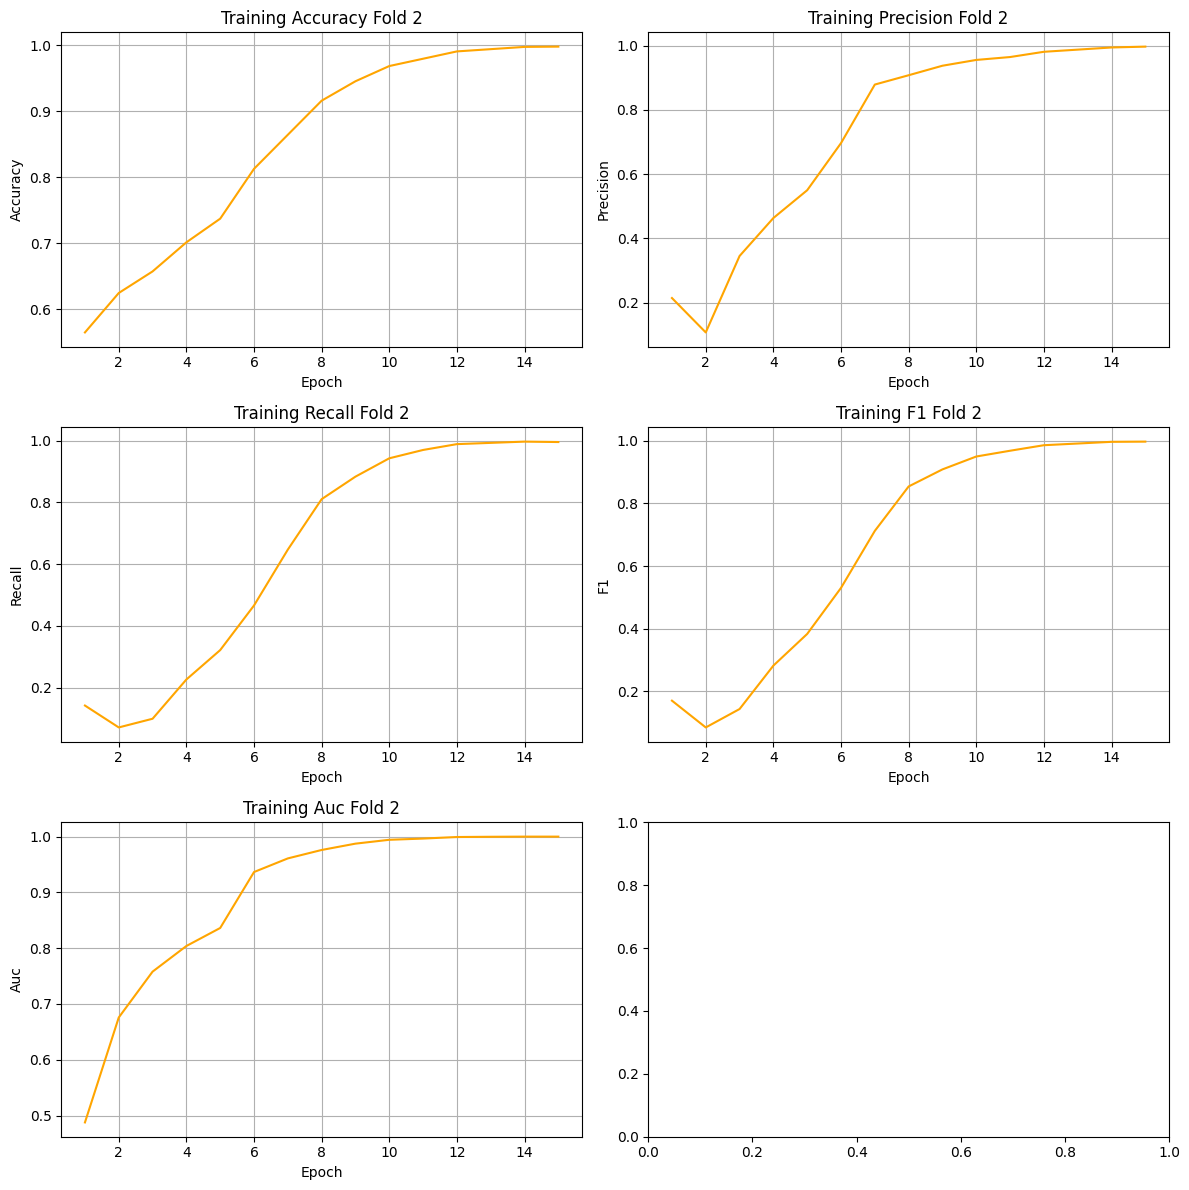

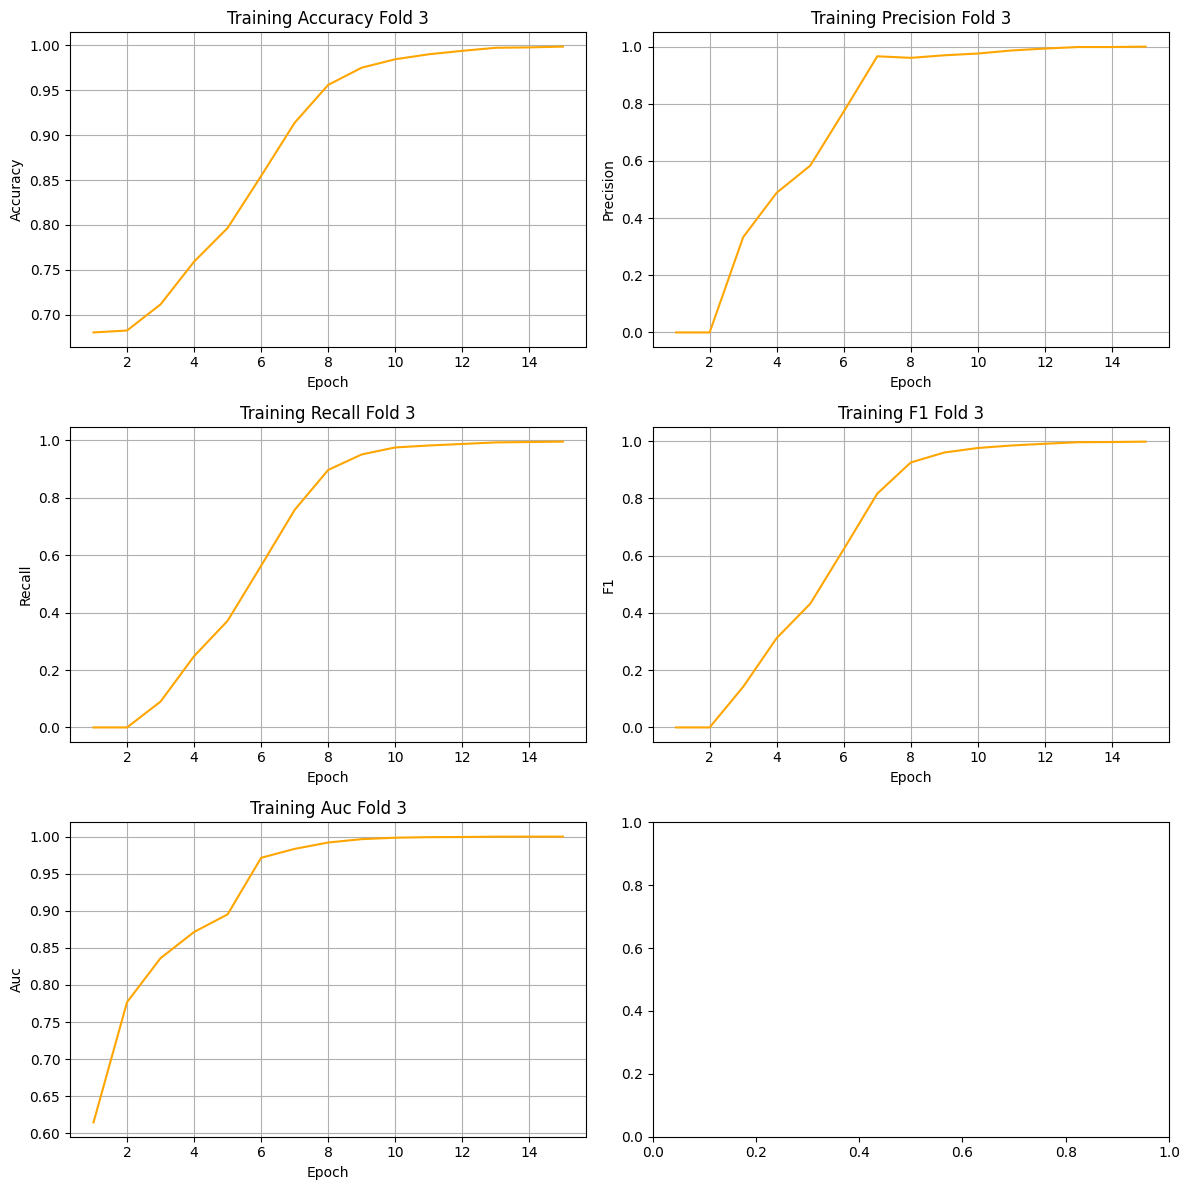

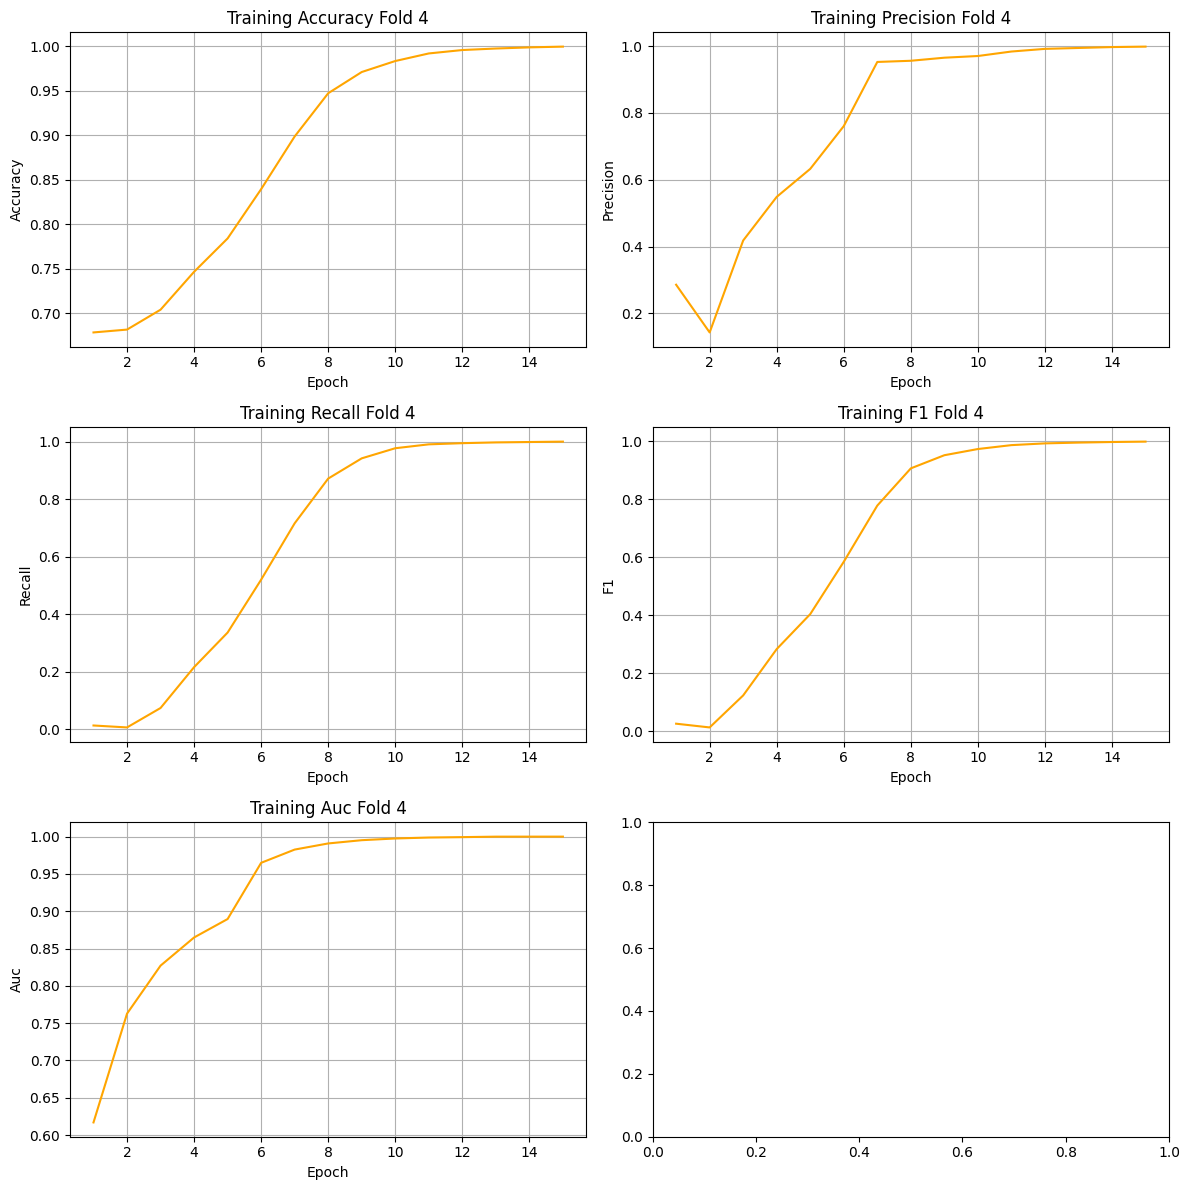

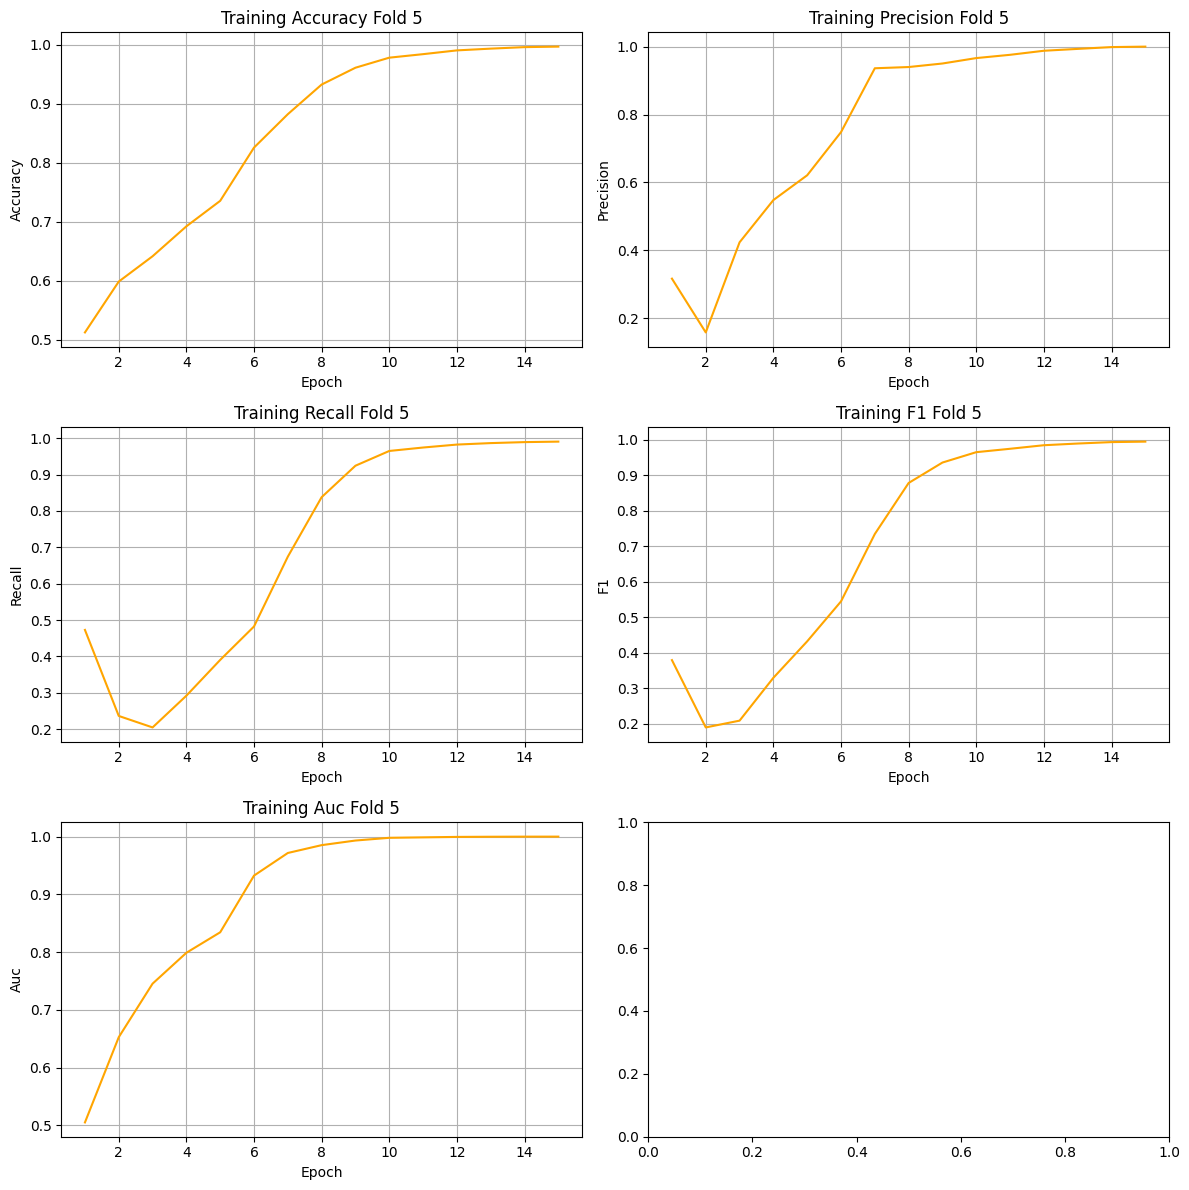

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to create a DataFrame for Species 1 only
def create_dataframe_species_1(fold_data):
    species_1_values = [data[1] for data in fold_data]  # Extract only Species 1 values
    df = pd.DataFrame({
        "Species 1": species_1_values
    })
    df['Epoch'] = df.index + 1  # Add 'Epoch' column (starting from 1)
    return df

# Function to plot metrics for Species 1
def plot_metrics_for_species_1(fold_number, per_epoch_accuracy, per_epoch_precision, per_epoch_f1, per_epoch_recall, per_epoch_auc):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    # Create subplots for each metric (single species)
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))

    # For each metric, plot the values with moving averages
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2

        # Select the appropriate data for the current fold and metric
        if metric == 'accuracy':
            data = per_epoch_accuracy
        elif metric == 'precision':
            data = per_epoch_precision
        elif metric == 'f1':
            data = per_epoch_f1
        elif metric == 'recall':
            data = per_epoch_recall
        elif metric == 'auc':
            data = per_epoch_auc
        
        # Create a DataFrame for the metric data (Species 1 only)
        df = create_dataframe_species_1(data)
        
        # Calculate the moving average for Species 1
        df['Species 1 MA'] = df['Species 1'].rolling(window=5, min_periods=1).mean()

        # Plot the values for Species 1
        axs[row, col].plot(df['Epoch'], df['Species 1 MA'], label='Species 1', color='orange')
        axs[row, col].set_title(f'Training {metric.capitalize()} Fold {fold_number}')
        axs[row, col].set_xlabel('Epoch')
        axs[row, col].set_ylabel(f'{metric.capitalize()}')
        #axs[row, col].legend()
        axs[row, col].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot metrics for each fold (Species 1 only)
for fold_number in range(1, 6):
    plot_metrics_for_species_1(fold_number, 
                               all_per_species_train_metrics['accuracy'][fold_number-1], 
                               all_per_species_train_metrics['precision'][fold_number-1], 
                               all_per_species_train_metrics['f1'][fold_number-1], 
                               all_per_species_train_metrics['recall'][fold_number-1], 
                               all_per_species_train_metrics['auc'][fold_number-1])
